In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sir import SIR
from data_loader import DataLoader
from constants import Periods
from constants import Countries

In [6]:
dloader = DataLoader()

In [3]:
pop = dloader.get_population(Countries.USA, 2010)
print("Population of USA in 2010: " + str(pop))

Population of USA in 2010: 309321666.0


In [4]:
covid19 = dloader.get_covid19(Countries.GERMANY)
print("Germany's COVID-19 infection data in first 10 day.")
print(covid19[5:15])

Germany's COVID-19 infection data in first 10 day.
   Start date   End date  Infected  Recovered  Death
5  2020-01-27 2020-01-27       1.0        0.0    0.0
6  2020-01-28 2020-01-28       3.0        0.0    0.0
7  2020-01-29 2020-01-29       0.0        0.0    0.0
8  2020-01-30 2020-01-30       0.0        0.0    0.0
9  2020-01-31 2020-01-31       1.0        0.0    0.0
10 2020-02-01 2020-02-01       3.0        0.0    0.0
11 2020-02-02 2020-02-02       2.0        0.0    0.0
12 2020-02-03 2020-02-03       2.0        0.0    0.0
13 2020-02-04 2020-02-04       0.0        0.0    0.0
14 2020-02-05 2020-02-05       0.0        0.0    0.0


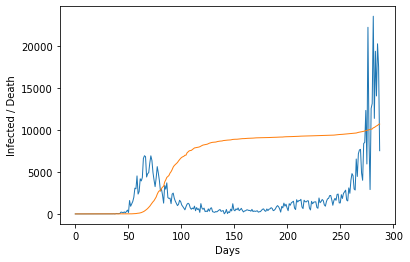

In [5]:
number_of_data = len(covid19["Infected"])
t = np.linspace(0, number_of_data, number_of_data)
plt.plot(t, covid19["Infected"], '-', linewidth=1)
plt.plot(t, covid19["Death"], '-', linewidth=1)
plt.xlabel("Days")
plt.ylabel("Infected / Death")
plt.show()

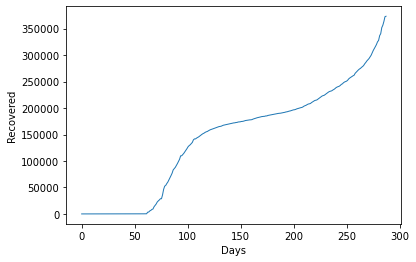

In [6]:
plt.plot(t, covid19["Recovered"], '-', linewidth=1)
plt.xlabel('Days')
plt.ylabel('Recovered')
plt.show()

In [7]:
infected_day = dloader.get_influenza(Countries.GERMANY, Periods.DAY)
infected_day = infected_day[0:120]
print("Germany's influenza infection data in first 120 day.")
print(infected_day)

Germany's influenza infection data in first 120 day.
    Start date   End date  Infected
0   2018-01-01 2018-01-01         6
1   2018-01-02 2018-01-02        13
2   2018-01-03 2018-01-03        19
3   2018-01-04 2018-01-04        26
4   2018-01-05 2018-01-05        32
..         ...        ...       ...
115 2018-04-26 2018-04-26         3
116 2018-04-27 2018-04-27         2
117 2018-04-28 2018-04-28         2
118 2018-04-29 2018-04-29         1
119 2018-04-30 2018-04-30         1

[120 rows x 3 columns]


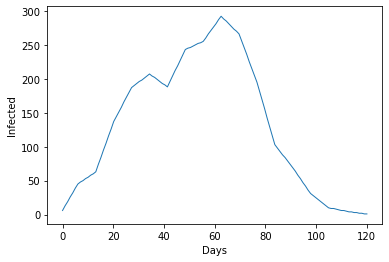

In [8]:
number_of_data = len(infected_day)
t = np.linspace(0, number_of_data, number_of_data)
plt.plot(t, infected_day["Infected"], '-', linewidth=1) 
plt.xlabel("Days")
plt.ylabel("Infected")
plt.show()

In [9]:
infected_week = dloader.get_influenza(Countries.GERMANY, Periods.WEEK)
infected_week = infected_week[0:2]
print("\nGermany's influenza infection data in first 2 week.")
print(infected_week)


Germany's influenza infection data in first 2 week.
   Start date    End date  Infected
0  2018-01-01  2018-01-07      45.0
1  2018-01-08  2018-01-14      63.0


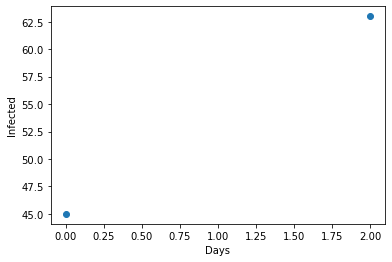

In [10]:
number_of_data = len(infected_week)
t = np.linspace(0, number_of_data, number_of_data)
plt.plot(t, infected_week["Infected"], 'o', linewidth=1) 
plt.xlabel("Days")
plt.ylabel("Infected")
plt.show()

In [69]:
def opt_covid(start_date, end_date, country, lmfit_value, opt_min, opt_max, brute_step=0, 
              method="differential_evolution", province="", population=0):
    data = dloader.get_covid19(country, province)
    data = data.loc[(data['Start date'] >= start_date) & (data['Start date'] <= end_date)]
    
    opt = {}
    if population > 0:
        opt["N"] = population
    else:
        opt["N"] = dloader.get_population(country, 2019)
        
    opt["Infected"] = data["Infected"].values
    opt["Recovered"] = data["Recovered"].values
    opt["I0"], opt["R0"] = opt["Infected"][0], opt["Recovered"][0]
    opt["S0"] = opt["N"] - opt["I0"] - opt["R0"]
    opt["y0"] = opt["S0"], opt["I0"], opt["R0"]
    opt["model"] = SIR(N=opt["N"], lmfit_value=lmfit_value, opt_min=opt_min, opt_max=opt_max, brute_step=brute_step)
    (opt["gamma"], opt["beta"], opt["report"]) = opt["model"].get_optimal_parameters(data=opt["Infected"], 
                                                                                     method=method)
    
    return opt

def opt_influenza(start_date, end_date, country, lmfit_value, opt_min, opt_max, fillna=0):
    data = dloader.get_influenza(country, Periods.WEEK, fillna)
    data = data.loc[(data['Start date'] >= start_date) & (data['Start date'] <= end_date)]
    
    opt = {}
    opt["N"] = dloader.get_population(country, 2019)
    opt["Infected"] = data["Infected"].values
    opt["I0"], opt["R0"] = opt["Infected"][0], 0
    opt["S0"] = opt["N"] - opt["I0"] - opt["R0"]
    opt["y0"] = opt["S0"], opt["I0"], opt["R0"]
    opt["model"] = SIR(N=opt["N"], lmfit_value=lmfit_value, opt_min=opt_min, opt_max=opt_max)
    (opt["gamma"], opt["beta"], opt["report"]) = opt["model"].get_optimal_parameters(data=opt["Infected"], 
                                                                                     method="differential_evolution")
    
    return opt

def plot_result(opt, t=None):
    if t is None:
        t = opt["model"].get_linspace()
        
    if len(t) > len(opt["Infected"]):
        realI = np.zeros(len(t))
        realI[0:len(opt["Infected"])] = opt["Infected"]
    else:
        realI = opt["Infected"]
        
    pred = opt["model"].get_ode(t=t,y0=opt["y0"],ps=[opt["gamma"], opt["beta"]])
    pS, pI, pR = pred.T
    plt.plot(t, realI, 'o', linewidth=1)
    plt.plot(t, pI, '-', linewidth=1, c="r") 
    plt.xlabel("Days")
    plt.ylabel("Infected")
    plt.show()

In [12]:
# AUSTRIA
austria_c19_start_date = "2020-02-25"
austria_c19_end_date = "2020-05-11"
austria_c19_opt = opt_covid(start_date=austria_c19_start_date, 
                            end_date=austria_c19_end_date, 
                            country=Countries.AUSTRIA, 
                            lmfit_value=10, 
                            opt_min=0.1, 
                            opt_max=20.0)

Parameters([('gamma', <Parameter 'gamma', value=17.904635822215745, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.977303607733, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.5442756477324817, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.918269728898678, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.412028785496545, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.688384179289178, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.580654083469949, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.830842929457043, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.1390464145978045, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.96358150800264, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', 

Parameters([('gamma', <Parameter 'gamma', value=6.424725472541112, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.991645135932043, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.18497934778621397, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.8480898746517984, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.965879793989014, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.776431051507016, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.3290945589091505, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.1995899356003425, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.9370305446772647, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.2299398457536574, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=17.01190850635964, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.805427599945066, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.078136179993345, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.399971565300397, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.528177326391269, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.888486229886734, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.800985140690447, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=7.665068013672558, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=6.669406122450849, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.130619817113462, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=13.655748886238948, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.508981500002743, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.3599527019507689, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.827711490879364, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.984650619011813, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.915800858402969, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.447247408881692, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.3630241847967, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.573784285846088, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.692126787869174, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=18.806728345871, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.41263782318804, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.242708270350207, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.016677274594453, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.68723904811957, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.443361927785023, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.2479060235243, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.415759113157552, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.160152228102483, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.4114673907904135, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', 

Parameters([('gamma', <Parameter 'gamma', value=19.288290552221792, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.54532841150108, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.061974508433263, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.123303243067138, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.785509980134407, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.51468228724612, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.195180925244152, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.45948182723589, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.30779698477115, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.69018062616442, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=18.55532444095161, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.40348211644564, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.571226422020445, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.766440996677403, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.551924478963443, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.792561609418062, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.178515753314908, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.500418559709335, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=16.828348479799327, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=16.227092158358865, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=18.144348248329422, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.39607313023927, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.45063861729602, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.67511266004511, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.369350894171635, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.568418240308528, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.17003025633967, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.369387373986168, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.607227959178232, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.80556190987199, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=17.980731930263275, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.6154749113193, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.223720213502855, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.441559982271478, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.354776850057192, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.146467834038145, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.74804697455873, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.981533560169773, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.720780164958423, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.95565211748578, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=17.776187068763537, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.8245506826313, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.630159997172022, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.872862871544065, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.21656080288894, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.44129302318507, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=16.976981222833828, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.20116911340741, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.069136685671573, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.08436246612313, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=17.91733970350027, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.149715000973092, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.021549280625514, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.150319138315812, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.004230394012396, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.231747621434753, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.186797685542096, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.42366222786104, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.729089629474142, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.963751518355583, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=17.689756069344153, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.920737635537467, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.557005931123815, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.791601023324375, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.502799811219347, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.736984627067557, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.0668512589961, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.298220710242983, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.710131376397765, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.948810139892686, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=17.784893241890884, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.01948848145564, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.78489330447996, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.01948848145564, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784893241890884, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019488541028917, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.78495601856028, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019396525642897, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784956081148582, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019396525642897, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=17.784952475846083, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019400460749804, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784953178801413, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.01940055339331, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784953241389747, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.01940055339331, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784953178801413, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019400612967765, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784953242756664, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019400567242183, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=17.784953219116705, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.0194006216758, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784935866658163, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019396243982683, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784935929246714, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019396243982683, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784935866658163, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.019396303557194, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.784950350704122, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.01939984830286, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

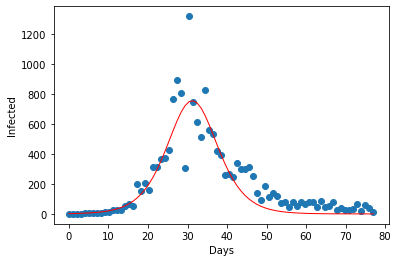

In [13]:
plot_result(austria_c19_opt)

In [16]:
austria_influenza_start_date = "2018-11-05"
austria_influenza_end_date = "2019-05-12"
austria_influenza_opt = opt_influenza(start_date=austria_influenza_start_date, 
                                      end_date=austria_influenza_end_date, 
                                      country=Countries.AUSTRIA, 
                                      lmfit_value=35.0, 
                                      opt_min=0.1, 
                                      opt_max=70.0)

Parameters([('gamma', <Parameter 'gamma', value=61.136984065741785, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=27.618865808061003, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=4.253807102495658, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=7.3364370436564705, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.7940355955285078, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=32.718849828812544, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=13.496774668797318, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=46.754820048751405, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=47.23597206282776, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=18.18591715393146, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.39424059156101, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=36.08357710480029, bounds=[0.1:70.0]>)])
Parameters([('g

Parameters([('gamma', <Parameter 'gamma', value=57.697581577664195, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=62.359427497727324, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.61459304335023, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=47.85516159057779, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.01798888679288, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=69.32526347102194, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=59.548619308742474, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=52.11992731190494, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=45.706737337921275, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=24.39526493162055, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=50.904418437472266, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=2.8719029800716105, bounds=[0.1:70.0]>)])
Parameters([('ga

Parameters([('gamma', <Parameter 'gamma', value=9.20646610515248, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=20.801879637812338, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=61.50474804402475, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=57.46294438405926, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.45501464702002, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=23.564695115791512, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=50.69889330746378, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=64.4383726181174, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=46.61342140243474, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=26.50149333402646, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.968993011210966, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=18.323006952672735, bounds=[0.1:70.0]>)])
Parameters([('gamma'

Parameters([('gamma', <Parameter 'gamma', value=20.51691351567995, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=68.60244210627792, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=44.81394008480394, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=45.29164693212875, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=1.1117741468589337, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=0.660796911060246, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=61.58133373391155, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=62.50838659750833, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.38146288368583436, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=69.91311799546344, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=62.77594083404214, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=59.57977149565576, bounds=[0.1:70.0]>)])
Parameters([('gamma

Parameters([('gamma', <Parameter 'gamma', value=31.55927325452534, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=33.044766735464215, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.1647955379611175, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=0.1239506572409093, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=50.070994486152, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=44.79535000849038, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=35.06324378198679, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=35.3626809359813, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.30965374597223, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=63.86429362882102, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=66.95103140808855, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=68.13952103502992, bounds=[0.1:70.0]>)])
Parameters([('gamma', 

Parameters([('gamma', <Parameter 'gamma', value=42.02510244470848, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=51.36100355863476, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=41.43491458838784, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=67.68815981958309, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=63.762531972854276, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=28.876239813648414, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.190481972027854, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=25.152029407425523, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=44.472887401362826, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=45.123222994768426, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=57.596773675117404, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=64.64879304298061, bounds=[0.1:70.0]>)])
Parameters([('g

Parameters([('gamma', <Parameter 'gamma', value=1.8591996037718748, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=64.32483665975481, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=34.94759338725887, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=40.00300145518773, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.24385629130752798, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=0.19358799302206814, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=40.86297183272998, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=66.51133988193858, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.563189159791367, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=52.586186704299216, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=41.11142651757726, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=41.424651730063424, bounds=[0.1:70.0]>)])
Parameters([('

Parameters([('gamma', <Parameter 'gamma', value=52.647827570856684, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=53.24313125747888, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=5.497155024838487, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=37.54792407011352, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=56.99004931370086, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=36.469624868485035, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=51.79489033041896, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=53.21899189095538, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=43.08168794002817, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=43.52590007236566, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=50.55398009982538, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=67.03322488062209, bounds=[0.1:70.0]>)])
Parameters([('gamma'

Parameters([('gamma', <Parameter 'gamma', value=55.234103783303674, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=55.79784112038912, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=45.4647154479592, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=59.39550131199782, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=62.80699438658073, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=63.3905075630104, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=35.53028691244259, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=53.21899189095538, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=67.27263963041669, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=67.74359704069573, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.81592226260498, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=44.10781060837813, bounds=[0.1:70.0]>)])
Parameters([('gamma', <

Parameters([('gamma', <Parameter 'gamma', value=38.82472680149154, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=39.217181249211514, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=45.97094087701843, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=46.45821703828534, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=50.06652194360243, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=50.624619551896544, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=44.06488941925067, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=44.567221897245346, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=41.83238015458293, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=42.34065878994102, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=43.68050883713964, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=44.16406652421742, bounds=[0.1:70.0]>)])
Parameters([('gamma

Parameters([('gamma', <Parameter 'gamma', value=43.95620276505129, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=44.39346710432814, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=46.10841777249313, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=46.82613790599901, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=49.56855647358855, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=50.33545532235977, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=40.027625825421566, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=40.50220769983768, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=45.99543098498591, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=46.484079783399324, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=47.707287261028775, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=58.49654300235434, bounds=[0.1:70.0]>)])
Parameters([('gamma

Parameters([('gamma', <Parameter 'gamma', value=38.53618450569386, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.55199949497224, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=45.14918816443441, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=45.62563958165998, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=57.173215379131136, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=57.684552215978705, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=46.500052731971884, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=46.971766129906044, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=51.764385445219894, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=52.294284501766775, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.423705756867676, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=44.93485758692689, bounds=[0.1:70.0]>)])
Parameters([('g

Parameters([('gamma', <Parameter 'gamma', value=50.53411699482754, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=51.03082452740836, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=47.27882813501198, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=47.772722917836674, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=46.39882039813137, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=46.89458792773228, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.546675425806875, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.045237777335096, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=49.13194445582445, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.630156404482086, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=46.65065468973258, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=45.53519540925312, bounds=[0.1:70.0]>)])
Parameters([('gamm

Parameters([('gamma', <Parameter 'gamma', value=47.755854562336324, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=48.251253047397704, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=47.87096387660425, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=48.37409798215937, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.52404744898818, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.02293215373319, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=49.099721061421285, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.600394672791964, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.72125968653651, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.22613806895125, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.63778416135424, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.13714788949168, bounds=[0.1:70.0]>)])
Parameters([('gamm

Parameters([('gamma', <Parameter 'gamma', value=48.917777144987916, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.42040959895678, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.51106270007988, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.84813284083911, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.44789378601172, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=48.94839301657653, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.97613982270908, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.48092164707905, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.764516306298574, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.265170115542865, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=49.21661852811602, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.72080388046162, bounds=[0.1:70.0]>)])
Parameters([('gamma

Parameters([('gamma', <Parameter 'gamma', value=48.71994563227944, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.221661142036545, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.719945310621995, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.22166146151526, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.7199453141342, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.22166151146746, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.719945635791646, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.22166151146746, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.7199453141342, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.221661830946175, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.719945105833176, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.221659907043446, bounds=[0.1:70.0]>)])
Parameters([('gamm

Parameters([('gamma', <Parameter 'gamma', value=48.71994531409899, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.22166183067494, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.71994531409896, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.22166151119595, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.719945635756396, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.22166151119595, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.71994531409896, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.22166183067466, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.71994531409899, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.221661511196224, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.71994563575643, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.221661511196224, bounds=[0.1:70.0]>)])
Parameters([('gamma

Parameters([('gamma', <Parameter 'gamma', value=48.7127142911567, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441602350358, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.712714612844856, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441602350358, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.7127142911567, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441634301442, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.70992053952119, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.209145163592034, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.70992086122122, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.209145163592034, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.70992053952119, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.209145483126235, bounds=[0.1:70.0]>)])
Parameters([('gamma'

Parameters([('gamma', <Parameter 'gamma', value=48.71271405004478, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441589199569, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.71271405647791, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441558149983, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.71271437816606, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441558149983, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.71271405647791, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441590101067, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.712714057831455, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441558339661, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.71271437951961, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.21441558339661, bounds=[0.1:70.0]>)])
Parameters([('gamma',

Parameters([('gamma', <Parameter 'gamma', value=48.706016076233084, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770552406685, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.70601575451648, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770584360745, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.7060159614816, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20769551859444, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.706016283198196, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20769551859444, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.7060159614816, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.207695838135066, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.70601576648063, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770494567475, bounds=[0.1:70.0]>)])
Parameters([('gamma',

Parameters([('gamma', <Parameter 'gamma', value=48.7060152099221, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770326692342, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.706015531638705, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770326692342, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.7060152099221, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770358646402, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.70601564510036, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770357309403, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.70601596681696, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770357309403, bounds=[0.1:70.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.70601564510036, bounds=[0.1:70.0]>), ('beta', <Parameter 'beta', value=49.20770389263462, bounds=[0.1:70.0]>)])
Parameters([('gamma', <

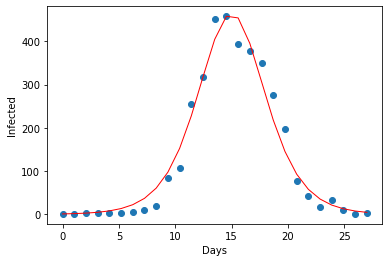

In [17]:
plot_result(austria_influenza_opt)

In [45]:
# CHINA all
china_influenza_start_date = "2018-11-05"
china_influenza_end_date = "2019-05-12"
china_influenza_opt = opt_influenza(start_date=china_influenza_start_date, 
                                    end_date=china_influenza_end_date, 
                                    country=Countries.CHINA, 
                                    lmfit_value=50.0, 
                                    opt_min=0.1, 
                                    opt_max=100.0)

Parameters([('gamma', <Parameter 'gamma', value=98.92425988670662, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=14.400573741788197, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=60.576444927530154, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=6.9259184415650115, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=3.9174245047052985, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=94.72573071276535, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.440208332041493, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=76.51071111257085, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=17.985422907137107, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=42.95081419210884, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.34012540194731333, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=48.69739461055915, bounds=[0.1:100.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=91.99425157662347, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=12.510849386208895, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.54567814601431, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=31.976098457726433, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=7.334065465707536, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=23.987420224213544, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=98.4865576414304, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=3.840436797436354, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=97.38695607674246, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.05923052688608, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=7.127871085221801, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.52428194736208, bounds=[0.1:100.0]>)])
Paramete

Parameters([('gamma', <Parameter 'gamma', value=65.32332342908887, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.48991887293523, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.32334881493804, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.4899208626696, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.32334929051426, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.4899208626696, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.32334881493804, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.48992133770764, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.3233518374521, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.4899211561327, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.3233523130283, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.4899211561327, bounds=[0.1:100.0]>)])
Parameters([('ga

Parameters([('gamma', <Parameter 'gamma', value=64.97891781795258, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.14523020588813, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=64.97891829462121, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.14523020588813, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=64.97891781795258, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.14523068203269, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.21022021462328, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.37670614085572, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.21022069056133, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.37670614085572, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.21022021462328, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.37670661626024, bounds=[0.1:100.0]>)])
Parameters

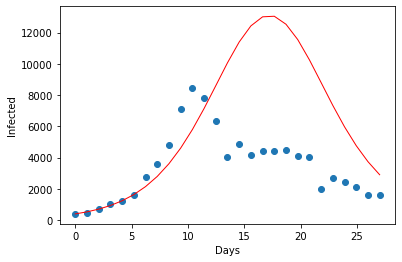

In [46]:
plot_result(china_influenza_opt)

In [70]:
# CHINA COVID 19, Bejing
china_c19_start_date = "2020-01-22"
china_c19_end_date = "2020-03-01"
population=21542000
china_c19_opt = opt_covid(start_date=china_c19_start_date, 
                          end_date=china_c19_end_date, 
                          country=Countries.CHINA,
                          province="Beijing",
                          population=population,
                          lmfit_value=50, 
                          opt_min=0.1, 
                          opt_max=100.0)

Parameters([('gamma', <Parameter 'gamma', value=0.49892784847571925, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=84.65547412276376, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=44.69770911571003, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=22.67153133924127, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=35.36408795225863, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=48.80666336917491, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=15.623752601431223, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=96.70006952851683, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.306252699184242, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.211229925089978, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=2.0129302566233127, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=71.14291209336733, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=46.137693423937684, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=95.03952890720124, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=24.937097457204768, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.68000844854068, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=63.36126846631675, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=90.59700349682826, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=58.102272545458256, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=36.00802016345766, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=37.06578116799605, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=81.52171719053884, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.98165146079268, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=74.11675146518577, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.62886916134754, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=65.63429158365798, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.549899109209399, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=96.06597723041305, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.419421152258893, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=63.4719459378536, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'g

Parameters([('gamma', <Parameter 'gamma', value=49.222855775112414, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=85.24745399599541, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=55.467912510581066, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=59.265776186676476, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.66781224168047, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=50.199242575720746, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=65.63755116289552, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=90.0247921848348, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=42.013401223556045, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.98590930791639, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=5.766295665877444, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=52.77443359493227, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=56.468023075807594, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=98.39650153424353, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=51.915158087821, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=63.36277021634477, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=55.52506056593423, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=75.55821318449132, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=20.961895228652313, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=90.42655641069094, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'g

Parameters([('gamma', <Parameter 'gamma', value=45.99604328280905, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=78.80406744246886, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=63.074368705387236, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=80.61966333291124, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=57.673844106457395, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=91.1448577921547, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=68.7149124813696, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=78.33561785359855, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=68.50888571683748, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=81.92369752582393, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'g

Parameters([('gamma', <Parameter 'gamma', value=87.1555954733447, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.946846759634983, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.840547425003916, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=78.15765013259771, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=86.89673313167818, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=58.753010789857605, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.02303773344226, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=49.231980724698005, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=96.1976933622263, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=53.72239982133968, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 

Parameters([('gamma', <Parameter 'gamma', value=76.5244859436853, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=46.10488836747879, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=69.38399253317023, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=71.43016751796699, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=68.65210772357413, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=98.58333261538118, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=51.057378613339715, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=79.9224470467232, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=53.10833329740809, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=77.1752362773428, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=23.389828262907507, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=66.00609185143715, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.08725569997558, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=46.520588206749565, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=68.26140540877114, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=54.1836526789104, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=78.06778700016129, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=78.9112635117908, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=87.48471109785017, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=82.32630811003035, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'g

Parameters([('gamma', <Parameter 'gamma', value=73.82321181333319, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=66.74749813837876, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=70.42969907304874, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=61.81615427639362, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=43.06617581307148, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=80.67416141677751, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=87.04812534203197, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=70.22131042788422, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=38.666239600864344, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=63.85526772551261, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter '

Parameters([('gamma', <Parameter 'gamma', value=71.123354845472, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=72.08063741890173, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=98.18189649974943, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=76.87750956997318, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=49.17902839877666, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=75.23183930088511, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=74.65901155723361, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=74.8927899098782, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=71.14645858532457, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=71.35463785007306, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=85.17102048997005, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=85.2921102170619, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=79.49671539458473, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=79.48416180645512, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=79.2696781874608, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=79.47126659591834, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=91.74178705986533, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=74.19559847092107, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=95.24400982924958, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=83.33516797605287, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=98.15761627406445, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=98.19541162883614, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.65203393833418, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.66756013602776, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.86293311766674, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.86568590261761, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=68.35431600234142, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=68.03350016987713, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=71.9136867425675, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=71.91213648430322, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=95.90916807722064, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.05955763489897, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=91.86071910420073, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=71.01391662531952, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=93.71574330801617, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=93.86366173939355, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.81115789696642, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.8370079867629, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=73.1639485177474, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=90.23563942710254, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=82.49328217506046, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.73549984499205, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.84290163492373, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.87094518289624, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.7429709134613, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.77597861813949, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=94.76213028659281, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=94.854771479835, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=97.44578990487408, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=91.36799809641546, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=99.06829705487245, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.162891022296, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=90.08606140394411, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=90.15372974421348, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.25929050588103, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.32176749538769, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.48595866688736, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.5535083633048, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.13595515303228, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.22631335374061, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=13.918659499403747, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=94.9197880021794, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.16251950695441, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.24373330377979, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=96.77758821919697, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=96.896165071133, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.97551355218987, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.98952708526375, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=97.5002593274119, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=97.61569498771664, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=99.80096668970486, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.85008313403335, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.90973659548511, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.9431884126423, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.16345266142783, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.47563570712796, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=97.66989623699475, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99930068528695, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.73578364075084, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=58.51240978779762, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=60.38232900843988, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.077336565898493, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.72723647175138, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.79263940455512, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.97401812459935, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99625714171148, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.57491242591317, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.65830690591518, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=77.90640124539797, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.30807674790318135, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 

Parameters([('gamma', <Parameter 'gamma', value=99.98569758347077, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.164907047305828, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.83013772253055, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.90746502316215, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.006772799049195, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=82.06482015563768, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.98947455799305, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.759113993627028, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.96891271395694, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99979797509445, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 

Parameters([('gamma', <Parameter 'gamma', value=1.5063509697482946, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.754342551575344, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.05331926370842, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=92.13633331343536, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.36955244801884, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.49533681540781, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.92634885095859, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.93072553034644, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.9286683764164, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.98779740829069, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'g

Parameters([('gamma', <Parameter 'gamma', value=17.174771014603454, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=52.958045643474996, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.8593924490402, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.95581250397635, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.85660110989484, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.96606945891025, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.85788203639069, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.98617108719665, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.92681951559608, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99589405826377, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter '

Parameters([('gamma', <Parameter 'gamma', value=99.89419763957397, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.95780029536519, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.92456375544603, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99785852267283, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.92135114099995, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99724727226, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.44126332019381, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.5887393816684, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=98.77772581684104, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.9751837390671, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=99.84287844211383, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.9805306777311, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.90633301562919, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99060079695047, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.90737801840685, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99088378827928, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.90972263158649, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.99343471946514, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.89615340039612, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.98178429340258, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=0.1, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=100.0, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.1, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=100.0, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.1, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=100.0, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.9036159737515, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.98837516159008, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.90361600476677, bounds=[0.1:100.0], brute_step=0>), ('beta', <Parameter 'beta', value=99.98837516159008, bounds=[0.1:100.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=99.9036159737515, bounds=[0.1:100.0], brute_step=0>), ('beta', <Pa

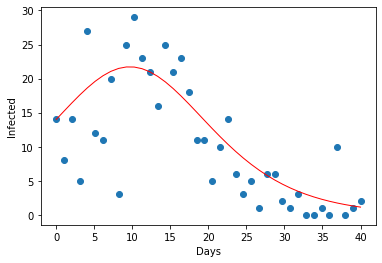

In [71]:
plot_result(china_c19_opt)

In [57]:
# CROATITA
croatia_c19_start_date = "2020-02-25"
croatia_c19_end_date = "2020-05-02"
croatia_c19_opt = opt_covid(start_date=croatia_c19_start_date, 
                            end_date=croatia_c19_end_date, 
                            country=Countries.CROATIA, 
                            lmfit_value=10, 
                            opt_min=0.1, 
                            opt_max=20.0)

Parameters([('gamma', <Parameter 'gamma', value=17.961563787680557, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.265675979315995, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.682834478519153, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.345235979591887, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.950028918990837, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.617902645372514, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.139893187267882, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.997674660440396, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.914687023354276, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.4712911418604213, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=19.73947407686085, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.159452998997974, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.1048067162162647, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.202424140908075, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=7.6468977725266996, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.5284976417228177, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.29487110763549773, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.05707294685027, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=16.812268627636282, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.4363715925664087, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=1.3342091516413073, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.96085630979048, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.1510405689767813, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.575325345437563, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.057085061926358, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.329865540310398, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.393508568436243, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.959806727283818, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.911211476844775, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.852235979462847, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=0.10000067992246611, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.202399450051365, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.304707580101846, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=15.871220332306475, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.98681718092855, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.854541980168944, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.04723955671629, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.1716075806693114, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.356060413958913, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.79119470616945, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=19.393508568436243, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.884433241717918, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=6.126425028475851, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.766630944474912, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=15.670564159260302, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.019669712491373, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.1538039595153395, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.5914480978538028, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.085363855667213, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.67635187083462, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=4.807202919537022, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.185470661487915, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=7.926760733567171, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.09645856216406, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.56350526380013, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.12218828667273639, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.14547453805884, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.8598908287191, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.301917382733844, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.471327171528014, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', v

Parameters([('gamma', <Parameter 'gamma', value=2.784647020477169, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.3656333958011544, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.143789052304122, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.27817926001974, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.404755848965316, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.964337998239518, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=7.283616742774629, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.854541980168944, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.835492815965914, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.4308052914895781, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=3.5148121735897586, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.95065221458246, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.788477265412071, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.713725592690935, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.09647386561379, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.11897750310143776, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.239413109310984, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.282354358650892, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.085363855667213, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=7.1328523655688, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=7.0767617018140285, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=6.541128345150524, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.967242435704966, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=15.09039530795278, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=16.923652904677137, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=16.989097720647525, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.37879923597975, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.663416507128126, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.84069912948106, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.111522589402679, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=6.585856378052341, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=7.338861646214072, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.32900079271056, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.102357046112004, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.38788252241077, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.61564532003791, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.55188707352741, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=17.086780362110517, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.93180891330351, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.640600927810882, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', v

Parameters([('gamma', <Parameter 'gamma', value=0.4275905602406802, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.7158017148108994, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.769704373078074, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.956113722427265, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.8662913973401345, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=6.126188931430488, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.354652965492438, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=6.932975744392531, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.66140294340131, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.798114466997593, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=19.521756897894655, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.657908265864766, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.566340743421414, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.72846866351956, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.66140294340131, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.974058346194074, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.81056781288057, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.91963019734344, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.68945446574334, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.802998092024293, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=19.132869439542304, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.20880667502292, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.753996527911905, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.882261164597296, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.477785636855064, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.981219659936695, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.773667772052033, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.923807833074267, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.325563353722295, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.819880874628478, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=19.514620496815656, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.987196941452883, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.904491028114318, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.9924399036934, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.714719560723882, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.745972784260452, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.761535520027792, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.07008550199208, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.032792809773987, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.964695255484795, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=19.732419276588672, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.879351164976864, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.84957899204033, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.984041169567003, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.837584596514592, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.973786558931636, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.864729200062808, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.963056077951585, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.802855023721655, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.984546246922402, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=19.857355880000785, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.954392095904673, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.86692711361122, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.9478183634924, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.846732700520253, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.983808639564767, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.86280892576458, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.993056877446683, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.841207485433134, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.98126872696548, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=19.845885477611382, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.995211764828376, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.852495785061333, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.991722793766638, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.842556249668462, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.983623122706923, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.840355344521733, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.98277956935933, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.865352009798197, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.995801650728602, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=19.832060016300115, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.975017627808644, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.812715825132063, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.98973388349185, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.797716688732876, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.941084328135076, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.871024059283798, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.996504288533746, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.836151112712532, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.986722778815324, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=19.889903406502732, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.677582448792226, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.856272466334882, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.996966838666687, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.781280160361575, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.615046472377056, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.852341269943683, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.9817807113625, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.864828534689355, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.98422343557268, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=19.8564189992303, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.99696978691288, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.85641898238795, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.996969789368325, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.856418553630615, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.996969790929125, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.85641857047299, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.996969790929125, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.856418553630615, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.99696979338457, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=19.85641765978368, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.99696997725595, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.85641765978368, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.99696997480058, bounds=[0.1:20.0], brute_step=0>)])
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1242
    # data points      = 204
    # variables        = 2
    chi-square         = 73212474.3
    reduced chi-square = 362437.991
    Akaike info crit   = 2613.31430
    Bayesian info crit = 2619.95054
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    gamma:  19.8564177 (init 

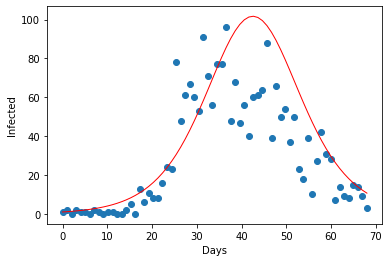

In [62]:
plot_result(croatia_c19_opt)

In [22]:
croatia_influenza_start_date = "2018-11-26"
croatia_influenza_end_date = "2019-04-28"
croatia_influenza_opt = opt_influenza(start_date=croatia_influenza_start_date, 
                                      end_date=croatia_influenza_end_date, 
                                      country=Countries.CROATIA, 
                                      lmfit_value=50.0, 
                                      opt_min=0.1, 
                                      opt_max=200.0)

Parameters([('gamma', <Parameter 'gamma', value=6.562901548921443, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=14.286219515157242, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=44.2506457498224, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=196.77965073205607, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.9734433279472, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=9.574317236491469, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=182.23633497388164, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=184.63804018494776, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=103.87954265113758, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=123.48475262498877, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.51200422639292, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=3.8165086334498577, bounds=[0.1:200.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=197.9989805964201, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=52.72674659372066, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.462977004991288, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=108.01721623956885, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.43472547805161743, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=98.3964171153898, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=106.73700259697894, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=160.66505252336916, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=17.492706117426888, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=93.42014233598526, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.3430778807141, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=107.31902885018745, bounds=[0.1:200.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=1.994997365418491, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=27.211148670581828, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=3.808671075788275, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=29.495287868543123, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=35.55075821468035, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=6.498486138563184, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.593386948842504, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=78.51979099757246, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=4.961014100481612, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=75.0351750014012, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=195.86771260845782, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.33142513502679, bounds=[0.1:200.0]>)])
Paramet

Parameters([('gamma', <Parameter 'gamma', value=82.38477477031896, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=178.82997432522583, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=49.11999033223427, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=50.96821877277364, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=182.05172626788107, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=193.02725678441206, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=10.255541286450052, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=1.154008682640213, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.51200422639292, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=4.965714867856824, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.155746450432705, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.79783931006583, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=11.497944833733586, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=184.73798061326474, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=97.72481340251541, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=192.31554716725176, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=195.81582215618633, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=134.49203730477655, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=4.130685849574438, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=4.853213565438678, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.1355812376493709, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.17364240478882353, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.56995909029357, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=61.823978725930395, bounds=[0.1:200.0]>)])


Parameters([('gamma', <Parameter 'gamma', value=0.39216015124162207, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.712519939338726, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=6.662865843081967, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=6.113343164248132, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.2625938856003773, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.8576158749534054, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=103.23106452461708, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=111.14185778912635, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.10006260490744902, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.7790875747345417, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.49234420112187105, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.964369839498591, bounds=[0.1:200.0]>)])

Parameters([('gamma', <Parameter 'gamma', value=3.809418700307152, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.2326961384219097, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=143.2943008714768, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=116.76603602942508, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=94.96078150830907, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=143.066916095735, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.462977004991288, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=151.0527001667272, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=39.588872379450436, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.975301774260664, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=59.142976027505796, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.17364240478882353, bounds=[0.1:200.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=115.75014700434319, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=115.5107429899389, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=10.829204078344455, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=77.66471833158619, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.20027129283063, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=95.92887900115875, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.511588345098662, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=37.11543195714877, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.13382236592823904, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=33.5217756183256, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=124.98911620995429, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=127.45022361466279, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=46.824196323963314, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=47.65031719490267, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=57.95504944943413, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=59.150322721319434, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=82.91374282335158, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=84.69194115013734, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=30.57177491800481, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=5.1704909789426745, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.948945164637074, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.15589625010569388, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=173.86883860304593, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=174.57859303779873, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=75.98847180577657, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=65.78759538111967, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=134.53225512119923, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=45.85794976492503, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.6091814875542815, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.7378114753774061, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=170.25497188748264, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=170.851010071365, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=91.00406424988769, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=91.92289475990755, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=52.87935332904978, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=53.50033571703202, bounds=[0.1:200.0]>)])
Paramet

Parameters([('gamma', <Parameter 'gamma', value=46.86697769682674, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=47.382105294801285, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=40.60325952983099, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=51.52299803817304, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=36.35633547658379, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=37.09802513201954, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=35.263283502743036, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.52199146058165, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=40.76179215260233, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=41.47926108062927, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=45.02015118471951, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=49.80889521236127, bounds=[0.1:200.0]>)])
Paramete

Parameters([('gamma', <Parameter 'gamma', value=46.26760865568208, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=46.97475393526475, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=36.967267669636506, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=37.564302935853775, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=41.04730802662927, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=41.78671110328859, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=44.297210753300185, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=45.00079766786026, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.891281360178574, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.48621420777566, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=44.77575581452883, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=38.341216993072806, bounds=[0.1:200.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=41.06814873450103, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=41.71351166564369, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.49605530377659, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=38.10849499725915, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=39.05883839201664, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=36.66406347173969, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.78754562401483, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=35.390354444778836, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=41.89970770430456, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=42.565069742688, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.0118593827541, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=37.686131782819906, bounds=[0.1:200.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=37.905449634100336, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=38.52439401532164, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.481414497785266, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.110894404868155, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.046700574869135, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=37.87166797429812, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.056151695477816, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=38.674038417828335, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.610827874966596, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.273678207952486, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.48759822711986, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=38.081221569603514, bounds=[0.1:200.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=38.92155365939833, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.538382693595636, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.44979348771024, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.06548785165143, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.12981414035171, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.190313576742064, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.963833673676945, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.56889547986899, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.165371376432724, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.62016659068394, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.89671683339012, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=38.50990978287603, bounds=[0.1:200.0]>)])
Parame

Parameters([('gamma', <Parameter 'gamma', value=38.45737905523111, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.07771973152627, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.45737984240019, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.07771973152627, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.45737905523111, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.07772052351009, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.45763280561833, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.0775935249534, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.457633592789406, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.0775935249534, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.45763280561833, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.07759431693624, bounds=[0.1:200.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=38.457578194313406, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.07762086041218, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.457579115289704, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.0776200680516, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.457579902460346, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.0776200680516, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.457579115289704, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.07762086003465, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.45757850744535, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.077620068300774, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.45757929461599, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=39.077620068300774, bounds=[0.1:200.0]>)])
Parame

Parameters([('gamma', <Parameter 'gamma', value=33.34620268159451, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=33.889478155286966, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=33.34620193724205, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=33.88947890447239, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=36.85791027182061, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=37.454137510223546, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=36.85791104620826, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=37.454137510223546, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=36.85791027182061, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=37.454138289438575, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.96102883932517, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=38.57369864724758, bounds=[0.1:200.0]>)])
Parame

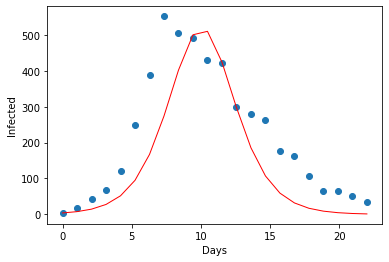

In [23]:
plot_result(croatia_influenza_opt)

In [24]:
# GERMANY
germany_c19_start_date = "2020-01-27"
germany_c19_end_date = "2020-06-10"
germany_c19_opt = opt_covid(start_date=germany_c19_start_date, 
                            end_date=germany_c19_end_date, 
                            country=Countries.GERMANY, 
                            lmfit_value=10, 
                            opt_min=0.1, 
                            opt_max=20.0)

Parameters([('gamma', <Parameter 'gamma', value=1.6301244403682282, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.098220232471866, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.265317375070294, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.186247433429859, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.489362508401046, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.71783678634609, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.2505412799723917, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.7060152928273314, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.18910927938201, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=16.963249268224335, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=17.88340507743673, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=16.685088663355405, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.4144538946069956, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.1134229107613268, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.0303931956632635, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.792252698242407, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.857895137416451, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.053239198678795, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.500767604240195, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.119129555867546, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=4.0303931956632635, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.262378269162387, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.027020214457619, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.10509454003181648, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.95422447006011, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.718649063044538, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.162800034697852, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.8728549576000157, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=16.989997448069857, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.80773019590431, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=18.7099976291316, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.01322287288421, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.796174217782509, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=16.09845491871119, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0490351468979, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.748171386252581, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.519568649846452, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.1650605276523152, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.871854020816118, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.533598647320742, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=0.7360144564867162, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.906214689406813, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.479789269805535, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.766846911226578, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.096383559515917, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.441100889994942, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.60565333807814, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.612872766844717, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.698964626631177, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=15.679892699561732, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=14.237845674876802, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=15.539248130539963, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=6.798951883246651, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.062095739755648, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.9629001438753, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.781729766514397, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.68655484059376, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.862610465404856, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.561163215074714, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.797747642395628, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=17.113739222505814, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=16.9805022069449, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.401634119642402, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=7.536494882796038, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.206835708707153, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.37380792857922, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.833998047493562, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=15.217383658669284, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.194489810740864, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.8224630129657, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', v

Parameters([('gamma', <Parameter 'gamma', value=19.460638420994883, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.6636510154024, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.25228244008604, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.349551945307933, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.030933580908947, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.263120255318455, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=19.981667663712138, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.50752632304904, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=16.82954940721747, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.641404323388677, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=18.785585930281126, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.9408345126856, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=18.43843649929113, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=18.66548383286288, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=16.62433455930855, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=19.940696639719594, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.190377352738109, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=15.690845841329661, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=16.263543505905147, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=16.264019833449435, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=11.0856735024155, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.835604703193795, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=15.238603968599627, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=15.408179654575736, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.199457618713987, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.401331322333599, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.248949590959526, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.395596375493414, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.39301678191102, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.592014038664429, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=10.582416765409349, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=16.021342375605606, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.416681285418909, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.567279947980815, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=17.852529723090324, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.294212778379618, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.861423795030287, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.709042217896753, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.985964372704142, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.20980644988665, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=12.77255387038279, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.94583740504273, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.579727873341364, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.586504660753622, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.451095841654856, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.600020070789379, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.01214622612722, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.142159783379185, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.638480862022083, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.785736082492665, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=13.251658358369106, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.399402670840564, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.846182704896778, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.004086395786079, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.951214024605244, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.102342399804536, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.441146246731769, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.596006235060997, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.880145276469502, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.03648361792934, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=11.588759732338264, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.748160412314643, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.72542847929775, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.36838665975538, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.512241193255855, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.657878622389024, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.031574642358732, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.230393232092393, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.980684403169297, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.136669197020385, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=12.409861891907608, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.564922383293712, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.827506238849468, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.978229229876646, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.590142393590437, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.920034250679043, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.737090599121013, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.884765011160999, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.170746055448276, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.317766514582448, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'g

Parameters([('gamma', <Parameter 'gamma', value=12.12981237816547, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.48641233996197, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.240196738640114, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.393307524011474, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.119498539041494, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.290710320242841, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.363948719033212, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.515740528182196, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.575059303856909, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.726154286203844, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=12.750787124000299, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.482851429916142, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.352754339171266, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.502806978562603, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.33261972809909, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.483961980962874, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.280221496633818, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.431525288722165, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.375867017458226, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.640213246266166, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=12.31552524516177, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466588088269386, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.315525148275292, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.46658818479016, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31553843240723, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466589549976572, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.315538529293677, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466589549976572, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31553843240723, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466589646497344, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=12.315539820624883, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466589799004373, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31553982315299, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466589702970815, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.315539920039432, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466589702970815, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31553982315299, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466589799491587, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.315539823377343, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.466589703014051, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=12.30302012946201, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.454008812135797, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.303020032546376, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.454008908687982, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.311450028226552, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.462479981934129, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.311450125122551, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.462479981934129, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.311450028226552, bounds=[0.1:20.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.46248007846518, bounds=[0.1:20.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

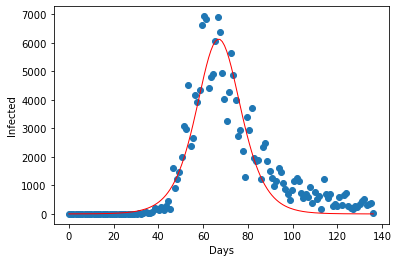

In [25]:
plot_result(germany_c19_opt)

In [111]:
germany_c19_opt_error = opt_covid(start_date=germany_c19_start_date, 
                                  end_date=germany_c19_end_date, 
                                  country=Countries.GERMANY, 
                                  lmfit_value=10, 
                                  opt_min=12.0, 
                                  opt_max=13.0,
                                  brute_step=0.01,
                                  method="brute")

Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.0, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.01, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.02, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.03, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.04, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.0

Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.69, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.0, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7

Parameters([('gamma', <Parameter 'gamma', value=12.01, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.01, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.01, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.01, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.51, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.01, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.01, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.19, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.2, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.21, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.84, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.85, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.86, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.02, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.03, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.03, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.03, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.03, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.03, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.03, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.04, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.05, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.06, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.07, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.08, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.76, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.77, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.78, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.79, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.8, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.04, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.05, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.05, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.59, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.05, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.6, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.05, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.61, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.05, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.62, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.05, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.21, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.24, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.25, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.76, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.77, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.78, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.79, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.8, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.06, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.07, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.07, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.07, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.73, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.07, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.74, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.07, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.75, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.07, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.08, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.54, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.08, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.55, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.08, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.08, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.57, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.08, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.08, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.27, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.28, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.29, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.3, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.31, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.85, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.86, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.89, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.09, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.1, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.1, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.53, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.1, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.54, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.1, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.55, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.1, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.1, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.

Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.04, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.05, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.06, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.07, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.08, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.51, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.53, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.54, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.55, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.11, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.12, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.13, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.14, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.15, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.16, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.89, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.9, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.91, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.92, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.12, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.94, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.95, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.96, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.97, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.98, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.13, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.14, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.92, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.14, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.93, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.14, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.94, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.14, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.95, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.14, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.96, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.14, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.15, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.15, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.15, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.15, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.15, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.15, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.28, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.29, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.3, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.31, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.32, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.77, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.78, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.79, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.8, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.81, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.16, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.97, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.98, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.17, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.99, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.0, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.01, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.18, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.24, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.25, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.26, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.89, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.9, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.91, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.19, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.2, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.62, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.2, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.63, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.2, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.64, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.2, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.65, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.2, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.66, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.2, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.

Parameters([('gamma', <Parameter 'gamma', value=12.21, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.21, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.21, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.21, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.51, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.21, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.21, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.24, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.25, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.26, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.83, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.84, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.85, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.86, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.22, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.23, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.36, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.23, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.37, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.23, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.38, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.23, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.39, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.23, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.4, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.23, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.03, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.04, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.05, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.06, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.07, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.63, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.64, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.65, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.66, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.24, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.25, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.25, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.59, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.25, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.6, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.25, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.61, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.25, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.62, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.25, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.26, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.26, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.53, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.26, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.54, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.26, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.55, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.26, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.26, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.27, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.27, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.27, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.27, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.27, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.27, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.28, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.32, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.28, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.33, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.28, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.34, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.28, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.35, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.28, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.36, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.28, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.19, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.2, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.21, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.69, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.29, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.3, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.3, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.3, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.3, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.73, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.3, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.74, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.3, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7

Parameters([('gamma', <Parameter 'gamma', value=12.31, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.64, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.65, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.66, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.31, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.32, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.57, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.32, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.32, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.59, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.32, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.6, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.32, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.61, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.32, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.33, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.54, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.33, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.55, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.33, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.33, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.57, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.33, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.33, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.34, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.34, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.34, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.34, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.51, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.34, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.34, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.35, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.35, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.35, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.35, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.35, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.35, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.36, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.32, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.36, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.33, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.36, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.34, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.36, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.35, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.36, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.36, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.36, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.3, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.31, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.32, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.33, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.34, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.77, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.78, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.79, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.8, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.81, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.37, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.38, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.39, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.38, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.4, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.38, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.38, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.38, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.38, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.39, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.39, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.39, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.39, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.39, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.39, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.4, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.4, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.4, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.51, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.4, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.4, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.53, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.4, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5

Parameters([('gamma', <Parameter 'gamma', value=12.41, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.41, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.41, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.41, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.41, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.41, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.33, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.34, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.35, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.36, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.37, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.83, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.84, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.85, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.86, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.42, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.38, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.39, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.4, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.89, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.9, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.91, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.43, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.44, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.44, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.57, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.44, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.44, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.59, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.44, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.6, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.44, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.45, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.73, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.45, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.74, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.45, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.75, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.45, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.76, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.45, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.77, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.45, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.46, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.77, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.46, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.78, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.46, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.79, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.46, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.8, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.46, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.81, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.46, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.29, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.3, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.31, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.32, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.33, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.89, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.9, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.91, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.47, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.94, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.95, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.96, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.97, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.98, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.48, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.49, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.49, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.69, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.49, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.49, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.49, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.49, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.5, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.5, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.73, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.5, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.74, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.5, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.75, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.5, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.76, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.5, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.

Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.24, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.25, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.26, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.27, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.28, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.89, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.9, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.91, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.51, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.52, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.59, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.52, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.6, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.52, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.61, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.52, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.62, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.52, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.63, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.52, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.53, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.53, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.53, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.53, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.73, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.53, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.74, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.53, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.24, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.25, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.26, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.27, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.9, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.91, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.92, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.93, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.94, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.54, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.55, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.55, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.55, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.69, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.55, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.55, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.55, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.56, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.56, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.56, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.69, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.56, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.56, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.56, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.57, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.57, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.57, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.57, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.57, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.59, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.57, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.6, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.57, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.58, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.53, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.58, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.54, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.58, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.55, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.58, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.58, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.57, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.58, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.59, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.84, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.59, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.85, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.59, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.86, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.59, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.59, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.59, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.6, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.4, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.6, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.6, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.6, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.6, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.6, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.4

Parameters([('gamma', <Parameter 'gamma', value=12.6, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.99, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.0, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.01, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.02, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.03, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value

Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.84, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.85, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.86, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.61, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.62, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.62, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.62, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.51, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.62, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.62, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.53, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.62, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.12, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.13, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.14, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.15, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.16, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.86, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.87, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.89, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.9, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.63, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.64, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.6, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.64, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.61, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.64, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.62, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.64, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.63, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.64, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.64, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.64, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.65, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.35, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.65, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.36, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.65, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.37, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.65, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.38, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.65, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.39, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.65, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.15, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.16, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.17, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.18, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.19, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.88, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.89, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.9, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.91, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.92, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.66, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.67, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.67, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.59, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.67, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.6, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.67, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.61, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.67, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.62, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.67, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.24, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.25, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.26, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.27, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.93, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.94, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.95, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.96, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.97, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.68, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.69, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.63, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.69, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.64, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.69, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.65, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.69, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.66, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.69, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.69, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.26, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.27, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.28, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.29, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.3, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.3

Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.95, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.96, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.97, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.98, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.7, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.99, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.71, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12

Parameters([('gamma', <Parameter 'gamma', value=12.71, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.71, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.69, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.71, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.71, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.71, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.71, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.72, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.4, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.72, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.72, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.72, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.72, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.72, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.11, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.12, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.13, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.14, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.15, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.92, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.93, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.94, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.95, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.96, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.73, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.74, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.74, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.69, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.74, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.7, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.74, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.74, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.74, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.75, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.75, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.75, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.75, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.75, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.75, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.76, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.27, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.76, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.28, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.76, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.29, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.76, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.3, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.76, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.31, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.76, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.2, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.21, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.24, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.94, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.95, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.96, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.97, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.98, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.77, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.78, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.65, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.78, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.66, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.78, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.78, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.68, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.78, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.69, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.78, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.79, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.79, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.79, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.79, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.79, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.79, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.8, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.21, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.8, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.8, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.8, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.24, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.8, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.25, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.8, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.

Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.09, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.1, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.11, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.12, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.13, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.95, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.96, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.97, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.98, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.81, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.99, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.82, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.82, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.73, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.82, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.74, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.82, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.75, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.82, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.76, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.82, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.77, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.82, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.83, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.55, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.83, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.83, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.57, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.83, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.83, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.59, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.83, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.84, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.84, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.84, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.44, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.84, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.45, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.84, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.46, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.84, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.85, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.39, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.85, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.4, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.85, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.85, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.85, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.43, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.85, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.86, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.19, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.86, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.2, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.86, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.21, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.86, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.86, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.86, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.0, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.01, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.02, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.03, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.04, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.73, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.74, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.75, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.87, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.88, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.54, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.88, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.55, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.88, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.56, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.88, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.57, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.88, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.58, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.88, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.89, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.33, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.89, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.34, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.89, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.35, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.89, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.36, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.89, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.37, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.89, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.9, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.15, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.9, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.16, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.9, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.17, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.9, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.18, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.9, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.19, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.9, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.

Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.12, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.13, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.14, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.15, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.16, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.97, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.98, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.91, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.99, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.0, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.01, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.71, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.72, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.73, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.74, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.75, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.92, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.93, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.63, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.93, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.64, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.93, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.65, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.93, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.66, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.93, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.67, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.93, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.94, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.47, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.94, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.48, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.94, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.94, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.94, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.51, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.94, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.95, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.27, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.95, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.28, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.95, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.29, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.95, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.3, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.95, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.31, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.95, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.96, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.49, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.96, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.5, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.96, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.51, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.96, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.52, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.96, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.53, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.96, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.97, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.38, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.97, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.39, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.97, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.4, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.97, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.41, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.97, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.42, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.97, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.98, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.19, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.98, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.2, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.98, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.21, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.98, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.22, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.98, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.23, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.98, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.02, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.03, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.04, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.05, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.06, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', val

Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.79, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.8, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.81, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.82, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', value=12.83, bounds=[12.0:13.0], brute_step=0.01>)])
Parameters([('gamma', <Parameter 'gamma', value=12.99, bounds=[12.0:13.0], brute_step=0.01>), ('beta', <Parameter 'beta', valu

<IPython.core.display.Javascript object>


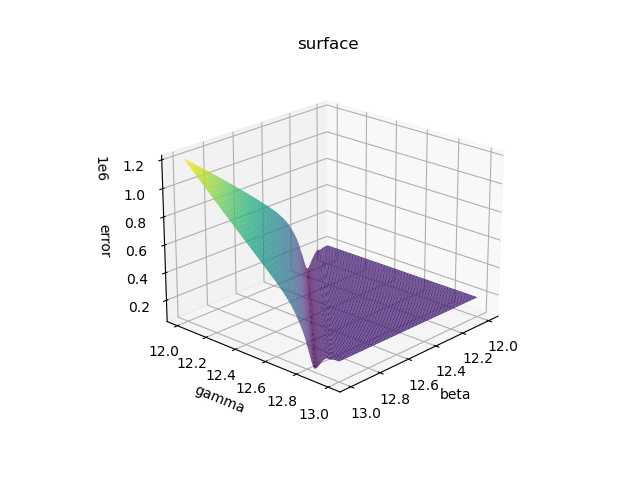

In [113]:
%matplotlib notebook
x = np.linspace(12.0, 13.0, 100)
y = np.linspace(12.0, 13.0, 100)
X, Y = np.meshgrid(x, y)
Z = germany_c19_opt_error["model"].get_errors()
Z = np.asarray(Z, dtype="float32")
Z = Z[:-1]
Z = np.reshape(Z, (-1, 100))

ax = plt.axes(projection='3d')
ax.plot_surface(X=X, 
                Y=Y, 
                Z=Z, 
                rstride=1, 
                cstride=1,
                cmap='viridis', 
                edgecolor='none')
ax.set_title('surface')
ax.set_xlabel("beta")
ax.set_ylabel("gamma")
ax.set_zlabel("error")
plt.show()

In [30]:
germany_influenza_start_date = "2018-10-22"
germany_influenza_end_date = "2019-05-06"
germany_influenza_opt = opt_influenza(start_date=germany_influenza_start_date, 
                                      end_date=germany_influenza_end_date, 
                                      country=Countries.GERMANY, 
                                      lmfit_value=150.0, 
                                      opt_min=0.1, 
                                      opt_max=200.0)

Parameters([('gamma', <Parameter 'gamma', value=178.03896036630582, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=110.48760562805765, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=145.36067664000564, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=64.23429807907387, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.2328122462362, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=31.94669372137781, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=3.990092039212733, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.247201754939, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=74.79662788352692, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=144.69714691989137, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=161.31632758912318, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=133.2168856202345, bounds=[0.1:200.0]>)])
Parame

Parameters([('gamma', <Parameter 'gamma', value=181.91851005187473, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=162.93525831240362, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=138.47760675538518, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=76.04702869617093, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=130.4816097715817, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=164.86528574276863, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=167.81819813841287, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=91.37947268217434, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=126.14647085402642, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=22.38532863917967, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.99314299015026, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=159.70090726024176, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=70.60951736141406, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=88.04391821127913, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=94.16915699995528, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=57.80701742349977, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=176.8546748522358, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=130.51651847138163, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.51587836566289, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=112.9673788568672, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.93068597951097, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=186.8306802581748, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=182.72650430256414, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=157.64766973610872, bounds=[0.1:200.0]>)])
Parame

Parameters([('gamma', <Parameter 'gamma', value=172.8681547094142, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=80.24451080071901, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=184.0875737610857, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=132.94510618615655, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=56.18297312396859, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=125.03960448006043, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=47.05113190570299, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=46.90163759914942, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=195.0920855419252, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=105.03687537483147, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.83756283606543, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.9606289365641, bounds=[0.1:200.0]>)])
Paramet

Parameters([('gamma', <Parameter 'gamma', value=152.9074282858785, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=180.70876212426043, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=175.5017656778134, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=178.72576735897007, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=56.61489532416961, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=87.28426084556044, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.76584813622682, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=185.09073277955923, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=114.27521357369952, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=146.71598401443097, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.7736661855561, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=177.7076623104367, bounds=[0.1:200.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=43.93039235556454, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=132.0345792681676, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=146.39474722042468, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.19444589663215, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=187.77318675404535, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=194.2404265696358, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=182.9534629338327, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=179.9079025404777, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.51587836566289, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=126.44902912054916, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=2.0291574645788613, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=160.4704352631422, bounds=[0.1:200.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=157.16865751153816, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=160.28597680951182, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=108.03441270623982, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=76.85981693284407, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=144.017307614905, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=150.00006381967412, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.93068597951097, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.26094167479945, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=153.8501862449144, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=185.75418647482059, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.829268770459, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.22159860986793, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=42.59691721070431, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=170.5756922593129, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.5109498984586, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=186.1228818439655, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=135.61176275012264, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=128.35114068238406, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=163.88578008711278, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=163.80613637249053, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=151.4236994258715, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=129.27658990683042, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=191.82964751581667, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=177.58190447364822, bounds=[0.1:200.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=145.05918737672152, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=164.66445906273023, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=103.05791688400713, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=132.45074527819912, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=104.09853082139847, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.59859850102094, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=119.0155516069132, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=159.9034095682774, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=82.9587169285335, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.45170532938258, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=195.52296557139414, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=186.13498550836914, bounds=[0.1:200.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=153.8501862449144, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=196.05138604962448, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=144.0632662379414, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=163.09529969217542, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=169.39826894899178, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=169.86279435562446, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=161.86264149595445, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=179.68968371193202, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=193.65782041522365, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=89.0644704780185, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=185.90599954990145, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=185.88186182034883, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=174.3656703271753, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.3339140352584, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=189.6259644618441, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=189.87021386099767, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=190.9225141997671, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=146.71598401443097, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=196.1097322766655, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=196.34465963962302, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=183.80213971484403, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=184.4341818853184, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=197.26190817848823, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=197.68845725962208, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=198.52926668501172, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=189.72391683234486, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=179.97696379910386, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.48164897294484, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=195.13163569243193, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=182.20644937288117, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.7456506181012, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.81168296015753, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.680729792896, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.06414208737675, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=192.29410832936472, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=197.54144078860242, bounds=[0.1:200.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=198.80655760804368, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.10409856194212, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.87237211127893, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.1853928441036, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.13650244353565, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.47209883349436, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.34401587085796, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.65594716310207, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.27784520086507, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=194.05266441271692, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.48290442551126, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.77007718670723, bounds=[0.1:200.0]>)])

Parameters([('gamma', <Parameter 'gamma', value=6.961182516371507, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=70.88480998710656, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.64061438053452, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.97254072147368, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.77234841008647, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.90885787976612, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=194.67793431780618, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=195.11252465788482, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=197.7538951512741, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.08606434441987, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=194.77207592083272, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=195.15425232001593, bounds=[0.1:200.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=196.42543356706943, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=196.84579377433997, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=190.42852196545712, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=190.58719367214744, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=197.97643112945934, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.3366465792609, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.60154214967685, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.9074621362574, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=197.4757567802399, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.34517541598996, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=193.63491235208744, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.0804370557106, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=198.75048570058993, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.09240414470753, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=196.24229480398785, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=196.63228972761289, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.93502622994814, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.2651875409541, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=195.61157797886315, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=195.9784261626134, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=197.96645306960917, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.32483818629547, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.7555021092592, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.0964298938043, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=197.60847096955018, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.00137806510796, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.36797648302186, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.73073991360093, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.20688102039625, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.1856317445161, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.4590453889483, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.82346434523552, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.75188458008816, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.1004619106889, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.05640740828804, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.44459092209962, bounds=[0.1:200.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=198.7818865026033, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.95025001464043, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.1571101273299, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4926995875059, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.92060576598158, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.2846879504122, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.65655235168384, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.03089722775178, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.74821311012892, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.93641737485498, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.31965163662062, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.64486670690724, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=198.66673862688498, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.04623372527848, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.05884907209386, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.42742879714308, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.41971500228445, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.79345865136386, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.34071314035234, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.67519145113582, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.25684469138068, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.60434180989435, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.0402291504988, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4058364647965, bounds=[0.1:200.0]>)])


Parameters([('gamma', <Parameter 'gamma', value=198.92695370046587, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.28912115023752, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.03539189471942, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.40145194631808, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.004531509041, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.373595930279, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.2549877155495, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=198.61243733230035, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.083583903539, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45031469995325, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.21217317721175, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.57181541828228, bounds=[0.1:200.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=199.10385343898707, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.47397057744243, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.1627704940663, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.53005487532613, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=198.8511470047632, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.47778515146297, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.17411889838874, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.43277656122166, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.05396839233583, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.42694378527517, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.05022811713738, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4233015397658, bounds=[0.1:200.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=199.07875368736643, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4507187359225, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07879908601274, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45071581316415, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07879922140086, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45071581316415, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07879908601274, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4507159178065, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07879573107286, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4507160214243, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.0787958664612, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4507160214243, bounds=[0.1:200.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=199.04358449546467, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45071462880213, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.0435843575253, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45071473344458, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07790677458465, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45071618757214, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.077906910038, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45071618757214, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07790677458465, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45071629221445, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07873842492913, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4507162256971, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=199.0787469602537, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45068065466754, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07874682486178, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45068075931317, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07878074539477, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45070714236985, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07878088078422, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.45070714236985, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07878074539477, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.450707247013, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.07878940742296, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.4507139063084, bounds=[0.1:200.0]>)])
Pa

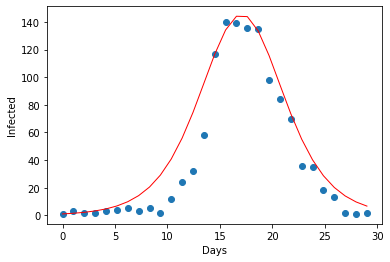

In [31]:
plot_result(germany_influenza_opt)

In [32]:
# HUNGARY
hungary_c19_start_date = "2020-03-04"
hungary_c19_end_date = "2020-06-16"
hungary_c19_opt = opt_covid(start_date=hungary_c19_start_date, 
                            end_date=hungary_c19_end_date, 
                            country=Countries.HUNGARY, 
                            lmfit_value=26, 
                            opt_min=25.1, 
                            opt_max=27.0)

Parameters([('gamma', <Parameter 'gamma', value=26.263771572389075, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.92475787246673, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.716709271069725, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.95662241163319, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.224835329474107, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.974319460123453, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.972328613994932, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.829055851779184, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.534616931228342, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.996696400293743, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=26.389403198283556, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.991295101697244, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.75956248604069, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.817852440659323, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.865723920212183, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.642608594035224, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.59115867713259, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.716609964095838, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.82878465560433, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.830406513344467, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=25.70877754820951, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.227465924400885, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.17655271228284, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.555138977915803, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.505108324255346, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.17367179316714, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.54196310871011, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.342051801399176, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.255724465896517, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.43144074079989, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=26.867627438932825, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.549509638186542, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.104256562960227, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.982299129028615, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.122006236798647, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.215910408668236, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.30175217169227, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.151996597618115, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.258316068000166, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.101122453361953, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Par

Parameters([('gamma', <Parameter 'gamma', value=25.11352991920529, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.20298036156587, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.45256688660111, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.711292279204464, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.32545516427663, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.443401987253488, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.775751083658363, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.849324589534895, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.55896471479707, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.93533293250157, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=25.19877017869201, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.038350907386082, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.110506912649434, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.11565456696286, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.23781959606945, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.90234781808874, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.26859291688721, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.393445378575695, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.33675310506345, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.452733297710978, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=25.759570360909937, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.85220825487425, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.428575414998875, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.51303851570517, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.45062443549923, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.426760102288302, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.99728777748622, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.224711944254604, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.147849905823264, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.28610755962672, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=25.25438992628235, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.352854485814785, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.809262428355094, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.892876990452507, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.177237937686236, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.84254188605408, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.26802385895628, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.461865497359895, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.171965877701915, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.28917255065898, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=25.3534527511453, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.539939242719708, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.262274614786584, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26446095437218, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.279920216351005, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.388142867985017, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.314147947539777, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.432188965263478, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.764611464355188, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.873239738509856, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=25.279249362596374, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.38594527520907, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.282567142593898, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.284617554787232, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.270587680061716, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.37260600859597, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.110004363470875, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.161129101807123, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.1774548892242, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.272568102106945, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=25.176241520764435, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.271072488284247, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.276174298759376, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.38853100098641, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.30259066842599, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.4027775265873, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.198262085999666, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.304252839387168, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.123613631253434, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.225796163582867, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=25.253222312520222, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.35872150673883, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.25322244672238, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.358724286467858, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.253222451895827, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.358724286467858, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.25322244672238, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.358724292984284, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.253222371761016, bounds=[25.1:27.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.358722730151992, bounds=[25.1:27.0], brute_step=0>)])
Parameters([('gamma', <Param

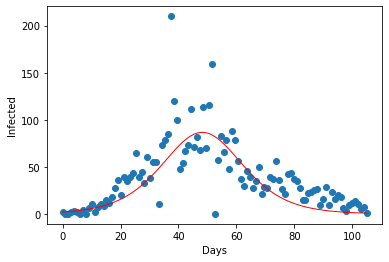

In [33]:
plot_result(hungary_c19_opt)

In [34]:
hungary_c19_start_date = "2020-08-02"
hungary_c19_end_date = "2020-12-31"
hungary_c19_opt_2 = opt_covid(start_date=hungary_c19_start_date, 
                            end_date=hungary_c19_end_date, 
                            country=Countries.HUNGARY, 
                            lmfit_value=5, 
                            opt_min=0.1, 
                            opt_max=10.0)

Parameters([('gamma', <Parameter 'gamma', value=1.6488210691732093, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3385586100623303, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.921264781208992, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.741143386947572, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=7.119311070462056, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.5400729632619696, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.5839604000264114, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.42351371537397586, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.222350621005052, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.4361997933382045, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=0.16596986643566386, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.795528309664475, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.346081489428649, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.223389652687048, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.107628505381847, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.825819838137111, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.8033240575859653, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.039153283471672, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.94994266192797, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.150436548084834, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', v

Parameters([('gamma', <Parameter 'gamma', value=8.79581429207208, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.554991329703043, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.762440505937342, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.3145271498057369, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.6227791220927232, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.20361224400944414, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.2486942687346945, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.457006525024278, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=6.312484454612044, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.6066787212762188, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=0.4563990668562743, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.9609095477097148, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.25408349703392, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.026095522367935, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.36131576524978304, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.7461110138889282, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.20899842448603, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.728119967641514, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.363895146796813, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.395885328826218, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', 

Parameters([('gamma', <Parameter 'gamma', value=2.4008645603098926, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.882331514781607, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.442341966724612, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.636149587820255, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.963471871400544, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.0895175463075382, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=6.000449689634099, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.105433288828359, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.3528887532756217, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.5262342222725622, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=0.23629463590422914, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.2531050464188511, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.442341966724612, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.675869252886745, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.579304013616637, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.23579895046994018, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.445698367472136, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.90148875431775, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.7056260452164262, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.7589134754626872, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=0.48987943482065177, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.5082823746207598, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.3190886810144724, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.7184712131533579, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.4736486896783243, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.654681818942649, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.3058526451991512, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.347151802796889, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.258710729385173, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.267407896200953, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=0.3901848770794879, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.054675931423814, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3091098291385137, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.361639295402627, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=6.066070210917567, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=6.014809435627125, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.4766017687280795, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.5797668192592873, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.163909834825187, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.219747691706185, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=1.5015645968793125, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.6472343050292464, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.350562009097368, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.410705836470513, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=6.396470559104435, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=6.546236777120284, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3660011362685442, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.264476406658107, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.10439224986214268, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.10764930273905184, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=1.8764506930043343, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.9715582434642793, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.5597665413076487, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.97331505413333, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.7878665132116516, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.784678480566712, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=7.78101429756111, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=7.774278010857735, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.680026555422853, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=7.28123562676689, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', va

Parameters([('gamma', <Parameter 'gamma', value=0.14369074351840455, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.5986891153025071, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.407360840091362, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.38830905313433217, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.5327280847461457, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.2075883565808012, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.246577738237383, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.3050773710841148, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.375156357182427, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.41330589174883803, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'g

Parameters([('gamma', <Parameter 'gamma', value=1.2792881200834192, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7679206811262937, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.21048875386076013, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.10792619999242009, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.0039856413644328, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.0922843837826404, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.010277076911371, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.49614985361231645, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.27626711958442873, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.261142850752099, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 

Parameters([('gamma', <Parameter 'gamma', value=9.961647993793619, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=6.199450839470179, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.3188405563102009, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.7650465795157304, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.5906860910051432, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.5998132599859605, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.5213087825524401, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=7.247826359301887, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.0034880305688219, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.0668650634354655, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=0.5156425741804019, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.5078959126485108, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.47073905313432396, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.515665311577932, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.422139167567904, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4192953989703683, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.27444613620563, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.340424517759688, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.2829663351282115, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.284034390570348, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=1.1115186542414515, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.1758012132928581, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.47325104257801753, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.5356809935509232, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.177033598527658, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.24511795365202, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.228293085493419, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.2971686836254115, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.2321378642034244, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.3037588710857204, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=0.9776919373868141, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.044289576808391, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.3752771774558712, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.441520854953973, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.2581710176956185, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.1777014635885468, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.9645303725727793, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.0319073210968688, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.9387963069054407, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.004922553196185, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=1.5833745002551458, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.1310089322587427, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.625968809721396, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.6934412319169172, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.7087303721312253, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.7765027687526673, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.494921769151732, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.461548206634369, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.7199167511616789, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.7882350401075842, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=1.0580724154056147, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.9412700149999271, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.8443176746072802, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.9146501218992882, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.7699448024668507, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.2591528164038905, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.2346144106571475, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.302534801454448, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.508366910920258, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.6285764721704934, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=1.89162816988672, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.7468367335305337, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.0531929887693727, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.2939562718728426, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.3283418668456861, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.932742629199828, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.719040666535627, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.7871892898112618, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.6753251103185096, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.5005752770846343, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=1.9448409193137126, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.01375760858155, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9448409578630153, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.01375760858155, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9448409193137126, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.013757647675964, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9448380910852165, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.0137587468599474, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.944838129634496, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.0137587468599474, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma',

Parameters([('gamma', <Parameter 'gamma', value=1.9448372192883356, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.0137590992991656, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9448372192883363, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.0137590602047397, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9448372578376092, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.0137590602047397, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9448372192883363, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.0137590992991656, bounds=[0.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9448372192883363, bounds=[0.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.0137590602047397, bounds=[0.1:10.0], brute_step=0>)])
[[Fit Statistics]]
    # fitting me

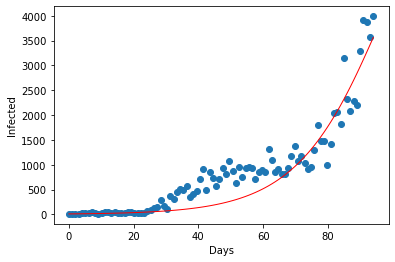

In [35]:
plot_result(hungary_c19_opt_2)

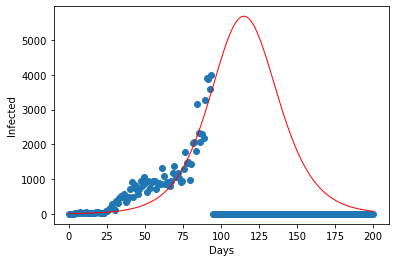

In [36]:
plot_result(hungary_c19_opt_2, np.linspace(0, 200, 200))

In [39]:
hungary_influenza_start_date = "2018-12-10"
hungary_influenza_end_date = "2019-05-19"
hungary_influenza_opt = opt_influenza(start_date=hungary_influenza_start_date, 
                                      end_date=hungary_influenza_end_date, 
                                      country=Countries.HUNGARY, 
                                      lmfit_value=150.0, 
                                      opt_min=0.1, 
                                      opt_max=200.0)

Parameters([('gamma', <Parameter 'gamma', value=45.41667627975404, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=145.50491710052106, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=123.5253796281301, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=108.82388638014032, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=195.92406268859273, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=42.39649692542627, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=39.713100347754136, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=67.35322434096526, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=82.0699254725199, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=33.107927865996025, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.763287141988027, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=2.787642390847002, bounds=[0.1:200.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=160.4614974485191, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=190.9648809121081, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=160.46149824478877, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=190.9648809121081, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=160.4614974485191, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=190.96488132737753, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=180.85298544190147, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=188.4771769822189, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=180.8529860301939, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=188.4771769822189, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=180.85298544190147, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=188.47717744811987, bounds=[0.1:200.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=186.67617241199488, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568452938772, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617827682423, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568282046036, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617877541298, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568282046036, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617827682423, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568330453215, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617413562988, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568368533895, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617463421874, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568368533895, bounds=[0.1:200.0]>)]

Parameters([('gamma', <Parameter 'gamma', value=186.67617437080725, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568374982803, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617437080727, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568326575627, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617486939614, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568326575627, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617437080727, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.4956837498281, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=186.67617437080727, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=187.49568326575627, bounds=[0.1:200.0]>)])
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 246
    # data points      = 69
    # variables        = 2
    chi-square 

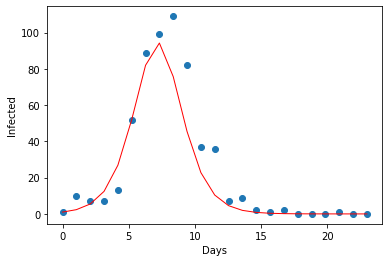

In [40]:
plot_result(hungary_influenza_opt)

In [43]:
# JAPAN
japan_c19_start_date = "2020-01-26"
japan_c19_end_date = "2020-05-25"
japan_c19_opt = opt_covid(start_date=japan_c19_start_date, 
                            end_date=japan_c19_end_date, 
                            country=Countries.JAPAN, 
                            lmfit_value=30, 
                            opt_min=25.1, 
                            opt_max=35.0)

Parameters([('gamma', <Parameter 'gamma', value=34.921389467830544, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.458401382075664, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.76173529157437, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.507908787838687, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.71373403305165, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.12761735979213, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.001622052145606, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.31377147902224, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.699827686895233, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.05806840416865, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=25.11448790868561, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.28960447098254, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.135955182469015, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.01514298788852, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.980937715643233, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.78798595324655, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.74040663365618, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.79525837826839, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.346625474562888, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.172351759023147, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=25.40454771754655, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.398623648453036, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.83485721543682, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.652960212650346, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.404584797929246, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.099471553898983, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.277983361626717, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.571328534745472, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.99338159805125, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.515747875519562, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=29.511379572959896, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.8900662577678, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.538488613143024, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.47224976285525, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.0817748015121, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.193054932142793, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.069921291703025, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.84313222243904, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.99642661967315, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.091605680310444, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=33.46683504358567, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.245429636287557, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.855592442625664, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.81107736176902, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.069921291703025, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.389051410603145, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.366163259022105, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.569339231253043, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.645694079188214, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.71620673078536, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=28.717346132273097, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.0619920888831, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.626668829199605, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.744018834709927, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.717346132273097, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.0619920888831, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.664231873386388, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.805108359210315, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.2871493991986, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.02398047506765, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=28.49645456015345, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.97477048310237, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.834013256598634, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.806007188123406, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.87260868329077, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.929081772277286, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.231877611906786, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.380024524153214, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.019696459290042, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.241969569202766, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=28.018385575377106, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.773126836942357, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.711419195026323, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.76319369625955, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.600229450649735, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.724749824624155, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.35163593953079, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.40123445810899, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.261245218611997, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.96573317887429, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=26.37456436659963, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.82350661781332, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.282008151984783, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.37027633739902, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.47335271079103, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.570826126073438, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.66632251814444, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.749715945041924, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.01116829653187, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.071185644812815, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=30.874980246665636, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.964490191466325, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.58818115059932, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.66610983902053, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.611784566060756, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.54479969916741, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.1193125800168, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.194662501698105, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.235978211777795, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.322151995555316, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=32.2844920377106, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.81290662479528, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.69189711807171, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.77454116803998, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.514258163021115, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.259270720973895, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.364817699495475, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.40671299132889, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.962922133274326, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.025494077465474, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=33.628139632366285, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.70862887685102, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.29189004505207, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.38715242257848, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.43892481709489, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.525500902121685, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.40222135691198, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.489633605281355, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.86148339318973, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.932217362840674, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=32.936093193639024, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.009982601171316, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.72187388480492, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.6349483780873, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.35109244172935, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.06071099221317, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.30847884013633, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.66610983902053, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.99285037527858, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.87132335946284, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter '

Parameters([('gamma', <Parameter 'gamma', value=33.86640278999866, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.94842725384202, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.338712259827695, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.4134336772935, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.227978313344394, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.31193495700818, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.42786415927924, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.18044677695326, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.02743176499909, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.83017242997093, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter '

Parameters([('gamma', <Parameter 'gamma', value=33.959123836879854, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.04639839257269, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.946336361048, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.94842725384202, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.094398345222075, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.17801258671879, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.111933098149024, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.19700021445901, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.96746677155886, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.05413831111092, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter '

Parameters([('gamma', <Parameter 'gamma', value=34.2566421537162, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.34034811838872, bounds=[25.1:35.0], brute_step=0>)])
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 957
    # data points      = 363
    # variables        = 2
    chi-square         = 4.6978e+09
    reduced chi-square = 13013371.9
    Akaike info crit   = 5948.47461
    Bayesian info crit = 5956.26342
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    gamma:  34.2566422 (init = 30)
    beta:   34.3403481 (init = 30)
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
beta      34.34     25.1       35     None     True     None        0
gamma   

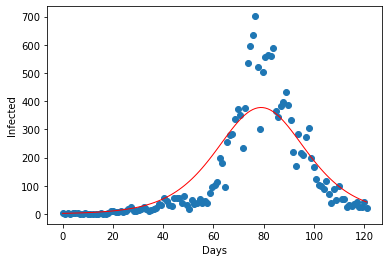

In [44]:
plot_result(japan_c19_opt)

In [45]:
# ROMANIA
romania_c19_start_date = "2020-02-26"
romania_c19_end_date = "2020-06-02"
romania_c19_opt = opt_covid(start_date=romania_c19_start_date, 
                            end_date=romania_c19_end_date, 
                            country=Countries.ROMANIA, 
                            lmfit_value=30, 
                            opt_min=25.1, 
                            opt_max=35.0)

Parameters([('gamma', <Parameter 'gamma', value=26.861230529923716, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.33923083323992, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.94618152270297, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.2229983351872, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.75990186058352, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.639609870081586, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.461335146898673, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.091080047669315, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.930168844637294, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.39488636055146, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=27.168017874129376, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.43555304768392, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.810960591735316, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.00735199853664, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.991338871075, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.92700602496931, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.210068847289747, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.547986851851757, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.100033509037317, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.37743776974779, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=25.895334592454358, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.74907532425132, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.55634244773608, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.794982467881496, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.21305245874982, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.286795296560044, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.33427110833314, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.426391262360738, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.400390144985337, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.826682351529684, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=25.177324170691165, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.016455450257293, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.42717170356292, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.778043176456386, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.353983748338294, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.801055626636433, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.30768108865401, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.845919258166234, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.864531746442424, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.32346386020869, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=25.634493671016596, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.645911242134158, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.068398101656935, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.228247169312013, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.05443368206053, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.428819577080894, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.94618152270297, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.629874369397868, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.296348943660178, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.646044640289027, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=25.159646184251002, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.664440415074896, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.968494721206383, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.457897683603843, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.138106707169303, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.160079886537634, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.699983574531586, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.238793104915196, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.9137436369375, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.295647115571885, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=25.113478775246733, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.22149321647942, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.29605106430753, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.81441166031302, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.227376755976035, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.45956875129696, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.150052383720386, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.177458617905085, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.331662409499774, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.465891974224554, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=25.12711455827173, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.28931137399104, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.18564049800104, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.288533848465555, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.17456536240778, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.32858354151079, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.483892788536046, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.354089282305193, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.332237534378784, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.589434595396504, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=25.272140751346114, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.414052862416728, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.151743647034547, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.297818196651956, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.10860903289751, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.258650023797298, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.128075776882792, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.28931137399104, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.147231400467145, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.32930783584108, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=25.21528219566193, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.292804804165545, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.165328606172427, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.311114604328683, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.1069845093307, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26348354003936, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.11029395403552, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.25083753300479, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.108495950211307, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.238439625560044, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=25.115469335139295, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.264607208389634, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.11546933122896, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.264607221048685, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.115469341642513, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.264607318638134, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.11546934555285, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.264607318638134, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.115469341642513, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26460733129719, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=25.115469342556302, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26460732831247, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.11546934646664, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26460732831247, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.115469342556302, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.264607340971526, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.115469342556302, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26460732831247, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.11546934646664, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26460732831247, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=25.115469342556306, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26460732831247, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.11546934646664, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.26460732831247, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.115469342556306, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.264607340971526, bounds=[25.1:35.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.115469342556306, bounds=[25.1:35.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.264607328312476, bounds=[25.1:35.0], brute_step=0>)])
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 717
    # data points      = 294
    # variables        = 2
    chi-square         = 1.2349e+10
    reduced chi-square = 42292647.0

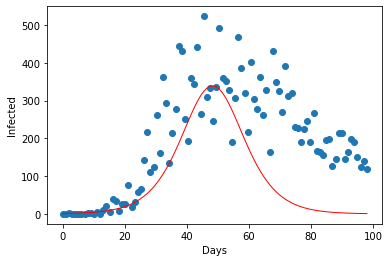

In [46]:
plot_result(romania_c19_opt)

In [51]:
romania_influenza_start_date = "2018-10-22"
romania_influenza_end_date = "2019-05-19"
romania_influenza_opt = opt_influenza(start_date=romania_influenza_start_date, 
                                      end_date=romania_influenza_end_date, 
                                      country=Countries.ROMANIA, 
                                      lmfit_value=150.0, 
                                      opt_min=0.1, 
                                      opt_max=200.0)

Parameters([('gamma', <Parameter 'gamma', value=0.11467007306005687, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=197.5164745916733, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=191.710750709846, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=142.7519790478685, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=31.471573935424885, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=8.363640153179615, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=118.37238117022851, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=4.782653291686546, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=168.10182035994538, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=84.39857001437345, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=5.450307575553225, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=130.38887547282133, bounds=[0.1:200.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=98.92349197173633, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=140.31316500086658, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.58085705510103, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=191.12086791859366, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=189.21303563238146, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=170.16533673807612, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=54.24189769857813, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=30.022822640876498, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=123.79958839194846, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.3628441431802, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=165.28761998823956, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.1247993780287, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=116.73840313350952, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.17983742239196, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=40.102495475553894, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=87.84102661018055, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=1.5456798770724298, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=150.41998781098928, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=128.97873258105164, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=13.145438080208654, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=141.41050749691075, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=64.34102445535498, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.58823979446913, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.23923811645913803, bounds=[0.1:200.0]>)])


Parameters([('gamma', <Parameter 'gamma', value=95.0917470304823, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.96334456007347, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=10.66412064524157, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=50.37554726692149, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=131.77526528099102, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=197.13376532660982, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=182.58251725182936, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=97.23515508138777, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=3.5719630829458104, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=126.43883229667485, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=6.7459545237122285, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=19.824609615480185, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=94.6778291854042, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=102.31136088500553, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=191.30225202699387, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.702458881320637, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=54.993374129775134, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=18.574471283891548, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.98080648257482, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=91.77266623562596, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=117.27359639389465, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=92.66042466235639, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=171.48857549921513, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=169.83166027804222, bounds=[0.1:200.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=98.00508213850229, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=114.61306832604114, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=165.57284986875467, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=133.02590056716556, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=104.06784993930852, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=106.63204027521506, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=33.62959686496906, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=126.75681892654399, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=92.66002019127548, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=88.49633427914475, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.3658176901779, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=27.032665995311955, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=0.8006596655527644, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.8515519601679264, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.3728141697755, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=22.570971241904143, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.49197183221284, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=199.6384050522977, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=39.19188478649526, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=47.918514767605146, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.8510821445314, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=35.84057649007458, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=172.78665529569076, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=186.56597031012265, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=80.58837184354209, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=192.3682042370554, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=18.291744314547177, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=18.222186865049157, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=199.72434016771146, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=195.62678072063463, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.69751166947502, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=60.55725942930414, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=105.26751702548412, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=131.27758497728388, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.12756417011156, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=27.43541283268826, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=114.70365209924707, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=116.1026929374157, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=143.96777799454276, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=18.976379155877364, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=113.35749868968193, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=161.09637043720613, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=1.026574458418327, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=93.60427452135848, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=59.85288461015079, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=59.367181754850414, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=42.82087625621006, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=41.22742222470944, bounds=[0.1:200.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=166.51952620622438, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=89.36406111134329, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=183.10370799040422, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=183.21139993456296, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=129.9966740951917, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=130.17364335649663, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=178.0835296602188, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=178.8908704344875, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=2.6409975259327716, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=62.943738089560256, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=118.7708926625287, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=119.11269141876907, bounds=[0.1:200.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=71.17809063376232, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=143.82139874315052, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=119.22159442511503, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=119.65609908323593, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=77.76532425709112, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=78.19825554091624, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=100.62800073419638, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=101.20091098559178, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=57.65427964362661, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=58.023006066341694, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=136.94429377682536, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=136.88926277072025, bounds=[0.1:200.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=138.67835382717132, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=138.96355138963952, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=94.81412557178507, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=95.23661748009555, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.10005600474467, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=90.51726236425012, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=76.78158242045906, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=77.10549466265336, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.62907419276249, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=158.8783990806068, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=65.15613545219112, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=65.55132445138483, bounds=[0.1:200.0]>)])
Paramete

Parameters([('gamma', <Parameter 'gamma', value=72.36119492687749, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=105.99892062763058, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=84.17099327998703, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=102.35924178048326, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=75.62217496271074, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=76.00473736076988, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=86.84883105936031, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=87.05358410137416, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=103.64902666380267, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=104.08671417353884, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=85.73341787680494, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=86.13015392719085, bounds=[0.1:200.0]>)])
Parame

Parameters([('gamma', <Parameter 'gamma', value=32.58893948306902, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=92.83859364037225, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.41314430500637, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=90.84709648891338, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=84.93952954328323, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=85.37419017218897, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=85.88421299490913, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=86.29706307269038, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=94.26947113151128, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=94.72922764354429, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=86.80445657192642, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=87.19081790528094, bounds=[0.1:200.0]>)])
Parameters

Parameters([('gamma', <Parameter 'gamma', value=85.14233215374382, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=86.63746466999044, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=73.16144802983354, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=73.57721257487059, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=85.20132272800633, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=85.61599510103699, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=84.32082774450097, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=84.70952813304301, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.3088752691719, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=80.71874433107061, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.32284748050138, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=80.73497321465157, bounds=[0.1:200.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=83.79874489116625, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=84.21543075259898, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=85.02854841714233, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=85.43650368350575, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=78.7848196085106, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=79.21380131250955, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=76.92808468005941, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=77.34406645909452, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.4862290013473, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.89172288715352, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.9096769395849, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=88.31309472212959, bounds=[0.1:200.0]>)])
Parameters([(

Parameters([('gamma', <Parameter 'gamma', value=83.67633953834634, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=84.09081891620822, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=84.63830835889131, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=85.05576341836719, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.77387489554296, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=84.15042013887528, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.6223476053608, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=82.91138962861383, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.68356895723198, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=84.09778176690662, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=82.01408114883716, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.19505942184895, bounds=[0.1:200.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=83.21345055488986, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.63018534697056, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.21344956967248, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.63018633289106, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=200.0, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.1, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=200.0, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.1, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=200.0, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=0.1, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=138.5473072380462, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=41.87816544673766, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=138.54730816043218, bounds=[0.1:200.0]>)

Parameters([('gamma', <Parameter 'gamma', value=83.21350826895782, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.63013814655375, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.21350728374033, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.63013913247416, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.2135072837325, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.63013814654997, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.21350826895, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.63013814654997, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.2135072837325, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.63013913247039, bounds=[0.1:200.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.21350728373952, bounds=[0.1:200.0]>), ('beta', <Parameter 'beta', value=83.63013814655336, bounds=[0.1:200.0]>)])
Parameters([('g

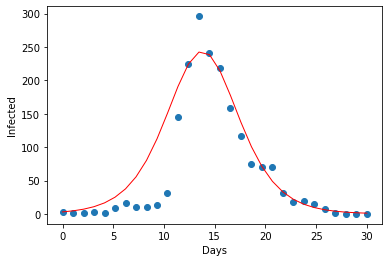

In [52]:
plot_result(romania_influenza_opt)

In [53]:
# SERBIA
serbia_c19_start_date = "2020-03-06"
serbia_c19_end_date = "2020-06-01"
serbia_c19_opt = opt_covid(start_date=serbia_c19_start_date, 
                            end_date=serbia_c19_end_date, 
                            country=Countries.SERBIA, 
                            lmfit_value=35, 
                            opt_min=25.1, 
                            opt_max=40.0)

Parameters([('gamma', <Parameter 'gamma', value=38.7630872821081, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.972087829310983, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.36132435769466, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.315501842662854, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.05231196507497, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.3561236438826, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.00634610084509, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.732848121702176, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.850943044617694, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.803812976400465, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=25.630458184763178, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.85058077289561, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.723480203715962, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.47333275810797, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.200854727319935, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=39.9407781932486, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=35.949001916847934, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.58083223665843, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.18643540074268, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.09049862003873, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=39.24554541556897, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.99614894910164, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.759154314016932, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.42033365945649, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.904754555336986, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.513295013737274, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.814998237105065, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.04917265556069, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.7847701316463, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=36.12071837994257, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=39.35496632854901, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=39.42163691268206, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.6142067570229, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=39.98250676122927, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.069071289008484, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=39.0253285651245, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=35.77767521411722, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=35.80756033506913, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.041774214081432, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.1913335925318, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=31.139352032619353, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.770520420403354, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.148824903019403, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.504544375523277, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.670455763470365, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.10580577727933, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.94679148254022, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=39.971945430030544, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.35854612743115, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=36.982130584451966, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=36.080895951260686, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=36.34575460047931, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.96124407730646, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.710018764163323, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.44800749033203, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.75767351955145, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.293298802398862, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.516666772858677, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.81026445981268, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.586509074255485, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=29.230264117444275, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.12270730837088, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.743031672031226, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.14924221426468, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.50024399527331, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.525568844278588, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.52119686902261, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.71034117176502, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.967553522268084, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.122932853829436, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=26.00037976222994, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.04665089477915, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.554321178653492, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.76167353961306, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.174709813517783, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.21731145695346, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.578201216183107, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.651223465573615, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.669824697048913, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.92501398995349, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=26.963936981048178, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.162562684534226, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.684254611861757, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.892576718054464, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.439491217433194, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.676817410120787, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.191546969727437, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.445329114171713, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.744830175076768, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.892030634544447, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Pa

Parameters([('gamma', <Parameter 'gamma', value=27.24383393415456, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.943049933547226, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.60772281769061, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.767588068206287, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.475158567284396, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.70963192395336, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.70688365304558, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.886926721460654, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.904454709244206, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.11175533525513, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=26.70688365304558, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.857894352082756, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.920034402752307, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.11175533525513, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.113464388757443, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.32513510235282, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.722074769409527, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.89670329525273, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.86471466159083, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.058144175105923, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=25.595822708126956, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.80496638238069, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.3618132998407, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.555300429295887, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.22289102980375, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.37906406535102, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.716215737933425, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.923477105564377, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.30119664271426, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.481801057387077, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=25.34353758942869, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.56470633543621, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.347811172028866, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.549522474938993, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.349771832061865, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.549625216867337, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.276963920042594, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.460553873442013, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.315976051513665, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.551834357992625, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=25.25358753752797, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.442263808856556, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.347811172028866, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.410479978359653, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.23213765532511, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.420742725207067, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.282731506566467, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.480297163824524, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.230743819667666, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.418575696778127, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=29.46568438773855, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.328582800921325, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.39456699593879, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.227663341710574, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.231047071432695, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.476346385695148, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.166577925390605, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.393055238539795, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.18355102649628, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.59150365919911, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=25.113016698412665, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.296000598653414, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.13411062435428, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.336426614820983, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.239782876505046, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.448779196446093, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.109567686799775, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.29359280224828, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.151507454061594, bounds=[25.1:40.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.345939676531348, bounds=[25.1:40.0], brute_step=0>)])
Parameters([('gamma', <Para

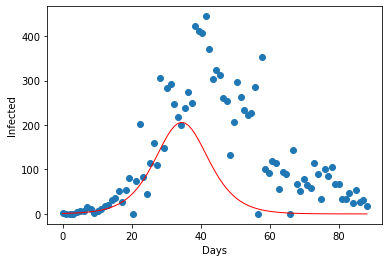

In [54]:
plot_result(serbia_c19_opt)

In [109]:
serbia_influenza_start_date = "2018-12-24"
serbia_influenza_end_date = "2019-05-26"
serbia_influenza_opt = opt_influenza(start_date=serbia_influenza_start_date, 
                                      end_date=serbia_influenza_end_date, 
                                      country=Countries.SERBIA, 
                                      lmfit_value=75, 
                                      opt_min=50, 
                                      opt_max=100)

Parameters([('gamma', <Parameter 'gamma', value=73.48433778818958, bounds=[50:100]>), ('beta', <Parameter 'beta', value=52.799469424693086, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.46969871261138, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.74201266270033, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=55.90457099752838, bounds=[50:100]>), ('beta', <Parameter 'beta', value=75.92888514250394, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=53.74874611511964, bounds=[50:100]>), ('beta', <Parameter 'beta', value=50.29149083949386, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=50.01317597774043, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.11336625987403, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.78201448729712, bounds=[50:100]>), ('beta', <Parameter 'beta', value=96.43876226555807, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', val

Parameters([('gamma', <Parameter 'gamma', value=77.58942108834023, bounds=[50:100]>), ('beta', <Parameter 'beta', value=94.52315814705315, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=78.93131318218728, bounds=[50:100]>), ('beta', <Parameter 'beta', value=67.30691662282747, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=95.85205659034625, bounds=[50:100]>), ('beta', <Parameter 'beta', value=52.48667128313936, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.0225731014944, bounds=[50:100]>), ('beta', <Parameter 'beta', value=91.98775247754423, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=85.15307049078265, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.59402904344503, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=55.518436133796165, bounds=[50:100]>), ('beta', <Parameter 'beta', value=95.466955211763, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=99.28701622451337, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.85168989591138, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=59.81205577585254, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.56793778668177, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=98.85437876618413, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.3579636661707, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=92.14267107702403, bounds=[50:100]>), ('beta', <Parameter 'beta', value=78.4985520305761, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=97.17678334965842, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.94436288994481, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=64.62863386216611, bounds=[50:100]>), ('beta', <Parameter 'beta', value=88.35845754040129, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=76.79912675392734, bounds=[50:100]>), ('beta', <Parameter 'beta', value=94.40049591209129, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.15917783786679, bounds=[50:100]>), ('beta', <Parameter 'beta', value=91.64906678098512, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=97.25183662254008, bounds=[50:100]>), ('beta', <Parameter 'beta', value=86.22077661090154, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=94.55747813385895, bounds=[50:100]>), ('beta', <Parameter 'beta', value=94.92854353962468, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.95904255972472, bounds=[50:100]>), ('beta', <Parameter 'beta', value=96.07713270395953, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=98.14853400473315, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.20060314505504, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', valu

Parameters([('gamma', <Parameter 'gamma', value=70.32393193832189, bounds=[50:100]>), ('beta', <Parameter 'beta', value=93.61282334215701, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.51594164140141, bounds=[50:100]>), ('beta', <Parameter 'beta', value=93.26866335085751, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.39694868665855, bounds=[50:100]>), ('beta', <Parameter 'beta', value=91.39000150961066, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=75.56414222508864, bounds=[50:100]>), ('beta', <Parameter 'beta', value=75.14377523652144, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=59.81205577585254, bounds=[50:100]>), ('beta', <Parameter 'beta', value=92.0520073324904, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=64.89209051268445, bounds=[50:100]>), ('beta', <Parameter 'beta', value=64.65617894334538, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value

Parameters([('gamma', <Parameter 'gamma', value=91.62877976648717, bounds=[50:100]>), ('beta', <Parameter 'beta', value=93.03249400415262, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.3075543694577, bounds=[50:100]>), ('beta', <Parameter 'beta', value=84.03174847703976, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=94.36467106988965, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.94436288994481, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=84.62859997611298, bounds=[50:100]>), ('beta', <Parameter 'beta', value=85.51601177575428, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.7064585266236, bounds=[50:100]>), ('beta', <Parameter 'beta', value=98.98172389586344, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=85.64864689802411, bounds=[50:100]>), ('beta', <Parameter 'beta', value=86.16793461129166, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=99.69035429339499, bounds=[50:100]>), ('beta', <Parameter 'beta', value=99.95257695786576, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=98.15153583432986, bounds=[50:100]>), ('beta', <Parameter 'beta', value=75.3572298472579, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=96.72168938891909, bounds=[50:100]>), ('beta', <Parameter 'beta', value=98.2329745301981, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.94941228145349, bounds=[50:100]>), ('beta', <Parameter 'beta', value=89.864097286824, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=82.69619519050552, bounds=[50:100]>), ('beta', <Parameter 'beta', value=83.81245081705384, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=79.19737963807755, bounds=[50:100]>), ('beta', <Parameter 'beta', value=91.17590725410048, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=85

Parameters([('gamma', <Parameter 'gamma', value=80.29402983556432, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.02435583312268, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=92.42618324179227, bounds=[50:100]>), ('beta', <Parameter 'beta', value=77.31082598581042, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=84.88040803895112, bounds=[50:100]>), ('beta', <Parameter 'beta', value=85.7584407090892, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.12195411468386, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.96489148519832, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=74.62769435465006, bounds=[50:100]>), ('beta', <Parameter 'beta', value=74.94736169193952, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=84.39188135050236, bounds=[50:100]>), ('beta', <Parameter 'beta', value=85.43934105746631, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value

Parameters([('gamma', <Parameter 'gamma', value=71.0241224508922, bounds=[50:100]>), ('beta', <Parameter 'beta', value=71.60185888466876, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.25209563729553, bounds=[50:100]>), ('beta', <Parameter 'beta', value=91.26600487509731, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.6293606431669, bounds=[50:100]>), ('beta', <Parameter 'beta', value=82.49539681161946, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=83.10841596814555, bounds=[50:100]>), ('beta', <Parameter 'beta', value=84.030768673385, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=78.92514449677392, bounds=[50:100]>), ('beta', <Parameter 'beta', value=79.78654729330378, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.87695446179066, bounds=[50:100]>), ('beta', <Parameter 'beta', value=85.37575400724721, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=79

Parameters([('gamma', <Parameter 'gamma', value=79.1310143524249, bounds=[50:100]>), ('beta', <Parameter 'beta', value=80.0248077116345, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=79.7339832022191, bounds=[50:100]>), ('beta', <Parameter 'beta', value=80.61365495902768, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=82.65380054017243, bounds=[50:100]>), ('beta', <Parameter 'beta', value=83.54256154889543, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.12324222099082, bounds=[50:100]>), ('beta', <Parameter 'beta', value=82.0080099923805, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.78738069479991, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.7493737927465, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.68883288873276, bounds=[50:100]>), ('beta', <Parameter 'beta', value=82.5890136692399, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.0

Parameters([('gamma', <Parameter 'gamma', value=80.89789617223649, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.78806675123236, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=79.95923040496373, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.09497454044505, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=79.91434066114867, bounds=[50:100]>), ('beta', <Parameter 'beta', value=80.82326325432568, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=79.42959491944929, bounds=[50:100]>), ('beta', <Parameter 'beta', value=80.32606568665614, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.18387576041215, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.0086297967377, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.61753654120409, bounds=[50:100]>), ('beta', <Parameter 'beta', value=82.16271395317489, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value

Parameters([('gamma', <Parameter 'gamma', value=80.23815741427464, bounds=[50:100]>), ('beta', <Parameter 'beta', value=82.12250831944897, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.81161130084881, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.71163828860921, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.08808892159784, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.99063010990638, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.35039062973657, bounds=[50:100]>), ('beta', <Parameter 'beta', value=80.84617307115005, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.27165774223893, bounds=[50:100]>), ('beta', <Parameter 'beta', value=82.17408702335932, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.58854186148292, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.47960216618213, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', valu

Parameters([('gamma', <Parameter 'gamma', value=80.3427533752325, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24509337173174, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.3428148092602, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24501131418256, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.34281505348434, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24501131418256, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.3428148092602, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.2450115562569, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.34281124925795, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.2450160552598, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.34281149348212, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.2450160552598, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.3

Parameters([('gamma', <Parameter 'gamma', value=80.34281360806416, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24501291036998, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.34281360806418, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24501266829564, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.34281385228833, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24501266829564, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.34281360806418, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24501291036998, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.34281360806418, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24501266829564, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.34281385228833, bounds=[50:100]>), ('beta', <Parameter 'beta', value=81.24501266829564, bounds=[50:100]>)])
Parameters([('gamma', <Parameter 'gamma', valu

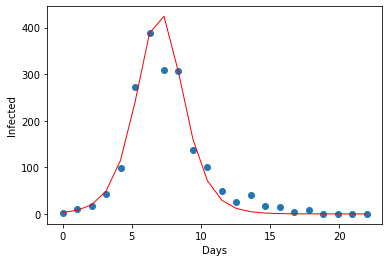

In [110]:
plot_result(serbia_influenza_opt)

In [64]:
# SLOVAKIA
slovakia_c19_start_date = "2020-03-06"
slovakia_c19_end_date = "2020-05-11"
slovakia_c19_opt = opt_covid(start_date=slovakia_c19_start_date, 
                            end_date=slovakia_c19_end_date, 
                            country=Countries.SLOVAKIA, 
                            lmfit_value=35, 
                            opt_min=25.1, 
                            opt_max=50.0)

Parameters([('gamma', <Parameter 'gamma', value=46.029445667012844, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.84424024966437, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.341738327693665, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.776751038745054, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.69569032777911, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=46.05833446986985, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.341351142282566, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.15101410640159, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.72655972451066, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=36.427051533232, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 

Parameters([('gamma', <Parameter 'gamma', value=32.896646229679234, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.446758223692047, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.121594266202685, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.103988020900708, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.584378662227337, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.915893859129387, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.10108928981694, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.72797490311958, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.161119830769515, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.390385351131272, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=27.239330544288883, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.52755091747153, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.422677162471498, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.65423672209434, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=47.6602416422799, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.21457634758064, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.28311905187817, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.277986594846027, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=46.87651216853226, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.133460624011278, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=45.05925371756955, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.220179601395543, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=45.71511679625465, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.262383866326623, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=48.268425111504854, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.106979468849424, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.806873030987198, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.13385539659619, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=48.63977851257251, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.87035796375042, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=25.160940037043755, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.35300392558247, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.20811376439627, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.842148556407334, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.352283868228135, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.77665062976125, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=48.691039892805534, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=46.243766091782746, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.567461662163588, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.38908535687286, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=41.40740246842349, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.528866967287755, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.73419641332403, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.133460624011278, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=47.84372356318998, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.764724450643453, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.28138404724127, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.63581266760747, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=46.12585495935792, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.0134326917733, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 

Parameters([('gamma', <Parameter 'gamma', value=25.96539162848501, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.343909191228548, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=38.51098985143509, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.142176412335175, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=43.88275535837271, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.651310007474716, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=40.343622527666625, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.219256093361032, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=44.11794975660051, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.65397860467236, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=25.88028769178265, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.501816585190515, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.137610999938392, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.014049942917097, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.256255743350977, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.806039168113475, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.269538130429286, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.738463190000886, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=49.32769975208544, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.272454182632128, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=26.316686540218758, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.423646410868376, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.890273416712436, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.051722875451606, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.62143248372998, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.572243400540525, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.416698738086538, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.497154046182228, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.54978482267451, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.551494865208458, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=26.97182670141979, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.798375336865835, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.847060708211025, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.271192645085634, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.461417055349237, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.597816109388663, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.970365338233925, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.112261371249616, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.233996110643805, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.208892954974043, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Par

Parameters([('gamma', <Parameter 'gamma', value=27.72770988225015, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.464294719111784, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.074069840225825, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.9541769943385, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.93338247429536, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.12094640141592, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=29.779963328990785, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.81751032858383, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.217051929514064, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.378455745732566, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=26.322319496118322, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.748076265506164, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.00891486986347, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.22963227195244, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.50019632113713, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.6654422608263, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.429288154530877, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.51727566169486, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.677043290838235, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.91187770883625, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=27.833585964865975, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=41.259380614374095, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=40.382876531070885, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.938807593909814, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=39.41485530914768, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.462660411226217, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.170000614178203, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=39.67979044813131, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=40.36578781937518, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=40.38842231270519, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=33.56294737527841, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.725976442094634, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.029574103022192, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.13108696460816, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=43.99375520232843, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=43.97332906059276, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.978442953529125, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.89041448454763, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.65189706796758, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=29.594798886808075, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=34.276439222793954, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=35.640347539053884, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=38.5720675986829, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.714849090825965, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=40.34762341178853, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=40.47971319620726, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.342934263683304, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=36.47838215295266, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=38.536464477638624, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.676353014670205, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=41.319309465893724, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=41.448785262652656, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.32913082451417, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=36.52249259144067, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=45.545687118957545, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.42233512087661, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=40.0617682602711, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.714849090825965, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.55826403435385, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=40.2403136137862, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 

Parameters([('gamma', <Parameter 'gamma', value=37.06260948251903, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.20189118750025, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.309565415054564, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.60087410043837, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=38.3119937421312, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=39.06877916619736, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.794510996723815, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.1582921487077, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.76050915770845, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.90250827862, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=37.43923443260306, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.579045650452635, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.439234308107984, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.5790457749523, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.43914616084999, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.579134171419284, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.43914628534505, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.579134171419284, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.43914616084999, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.57913429591895, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=37.43919117284199, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.57908890247347, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.43919129733706, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.57908890247347, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.43919117284199, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.579089026973136, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.439191218304735, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.57908879189526, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.4391913427998, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.57908879189526, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter '

Parameters([('gamma', <Parameter 'gamma', value=36.94707694881861, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.0833072599247, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.94707682446469, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.0833073843372, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.276734390025425, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.41544527081072, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.27673451449543, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.41544527081072, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=37.276734390025425, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.41544539530344, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'g

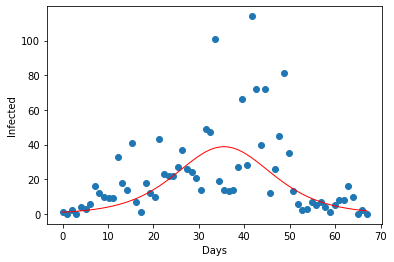

In [65]:
plot_result(slovakia_c19_opt)

In [66]:
slovakia_influenza_start_date = "2018-11-19"
slovakia_influenza_end_date = "2019-05-05"
slovakia_influenza_opt = opt_influenza(start_date=slovakia_influenza_start_date, 
                                      end_date=slovakia_influenza_end_date, 
                                      country=Countries.SLOVAKIA, 
                                      lmfit_value=50.0, 
                                      opt_min=0.1, 
                                      opt_max=100.0)

Parameters([('gamma', <Parameter 'gamma', value=6.075015720395307, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=98.39194275780456, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.6459572107810709, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=6.641479616336506, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=6.824242350985249, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=33.93274497654965, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=79.80322779324767, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=74.07423745173806, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.9922273869542, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=62.64418008463269, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=93.77177228561466, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=87.36995377608554, bounds=[0.1:100.0]>)])
Parameters

Parameters([('gamma', <Parameter 'gamma', value=0.3326144690775254, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.40781890482494, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.9922273869542, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.0271889297381, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=46.05230266750771, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=87.36995377608554, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=49.885137799540225, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.38858796572238, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=9.40472440125642, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=39.157916701383854, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=49.807181551516294, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=27.595931146706036, bounds=[0.1:100.0]>)])
Paramete

Parameters([('gamma', <Parameter 'gamma', value=6.43271216595385, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=80.40604691961593, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=96.94126931453992, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=97.47178520183962, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=82.52181422710855, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=60.41720726380899, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.33162960462654, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=88.50797774785262, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=78.82813954724583, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=94.1721058196733, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.575655392782853, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=95.5392561332089, bounds=[0.1:100.0]>)])
Parameters([

Parameters([('gamma', <Parameter 'gamma', value=28.482563344433675, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=93.81872752905657, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.27169124189793, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=1.9930461331969571, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=46.05230266750771, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=83.82835354043056, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.98383628990686, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.90912525284256, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=95.86261154191318, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=95.0897916805408, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=45.15912087641071, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=98.1994076776821, bounds=[0.1:100.0]>)])
Parameters

Parameters([('gamma', <Parameter 'gamma', value=79.29961675427441, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=23.862922226573787, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=38.99467534187233, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=92.93450122123026, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.9497826939494464, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=90.35611176155439, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=55.582079567240704, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=86.00014781034999, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=75.98427595063659, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=90.67400022478563, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.33352704409833, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.74276120196565, bounds=[0.1:100.0]>)])
Paramet

Parameters([('gamma', <Parameter 'gamma', value=99.52372335757428, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.83623970461863, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.28290108265223, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.30930547779033, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.65447571427748, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.93110907148916, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=77.73387431999853, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.62049406176779, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=98.62245305745351, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=98.80233521724878, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.320052091277347, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=4.793728646562089, bounds=[0.1:100.0]>)])
Parameter

Parameters([('gamma', <Parameter 'gamma', value=95.85630865495116, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.26952519220836, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=91.47145319076411, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=90.98781152780644, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=95.67437757198404, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=97.92027565832385, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=96.12334111616627, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.53451295124889, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=97.53654981285487, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=98.1794577053304, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=97.4605358387098, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=98.11191238082067, bounds=[0.1:100.0]>)])
Parameters([

Parameters([('gamma', <Parameter 'gamma', value=94.95075645485478, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.53451295124889, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.07406327830722, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=86.45468575827785, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=93.64810524791191, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=93.80471154439958, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=85.67199435223645, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=95.2457309292863, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=91.76286705987606, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=92.18045155432456, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.40558187629631, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=90.68146917096284, bounds=[0.1:100.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=86.54786380011657, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=86.96615815695199, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=95.92886327103945, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.72092808479991, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.7345963888872, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=90.38775290025866, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.5329550096496, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=80.78272718108822, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.04421493480802, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=95.2457309292863, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=78.63837306097422, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=78.88350326988564, bounds=[0.1:100.0]>)])
Parameters([(

Parameters([('gamma', <Parameter 'gamma', value=90.77810464122318, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=91.15029949371655, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.9960042740686, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=91.36513884938662, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.63033913009481, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=81.9856039336029, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=93.72901725402045, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=94.14210919427661, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=85.97720522471904, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=86.34332840820257, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=79.94729031351619, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=80.2560599191737, bounds=[0.1:100.0]>)])
Parameters([(

Parameters([('gamma', <Parameter 'gamma', value=87.18450860608043, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=92.31676915851214, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=92.55094609595912, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=92.92936252896676, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.66301353536878, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=88.06942332727021, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.83053670970806, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=88.2296271514427, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.75945864359824, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=91.14332000431118, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.78962754038552, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=91.15426464828016, bounds=[0.1:100.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=83.35300594573668, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=93.47479631683018, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.25562785865664, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=87.91602989350709, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.54343407461407, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=87.95337907472414, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=86.24994348842662, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=85.33096919228763, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.66301353536878, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=92.97558724769847, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.83053670970806, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.38301843364273, bounds=[0.1:100.0]>)])
Parameters

Parameters([('gamma', <Parameter 'gamma', value=85.48504590218015, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=88.2296271514427, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.9487373175685, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=88.35106435215694, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.93275226168542, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=90.3131294419634, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.46790521906674, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=86.57975039429398, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.53402659748373, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=88.93588076702399, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.25781733918097, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.6976234027761, bounds=[0.1:100.0]>)])
Parameters([('

Parameters([('gamma', <Parameter 'gamma', value=90.99090719616599, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=91.37543062560154, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.7362531237767, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.1394739948139, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.83053670970806, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=87.0858016286496, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.83980654576686, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=90.23257415306584, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=90.10237638370084, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=90.48921350840608, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.46790521906674, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=88.45559887359296, bounds=[0.1:100.0]>)])
Parameters([(

Parameters([('gamma', <Parameter 'gamma', value=88.79891518413629, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.19894011199568, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.97464574471459, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.37179905709252, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.04833209697905, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.44647787347535, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=87.34721276569468, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=87.75238728946987, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=86.11922879958804, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.1189601661422, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=88.69352394001587, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.09296177155278, bounds=[0.1:100.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=89.07427678655635, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47288671072468, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07427647476985, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47288701745558, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07497242055554, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.4727288346878, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07497273233336, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.4727288346878, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07497242055554, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47272914142074, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07432919509357, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47287475125451, bounds=[0.1:100.0]>)])
Parameters([

Parameters([('gamma', <Parameter 'gamma', value=89.07425976726667, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47264747054253, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07425945547993, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.4726477772765, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.0743014827223, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47285335108532, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.0743017945085, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47285335108532, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.0743014827223, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47285365781664, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.0743062540992, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47287672473098, bounds=[0.1:100.0]>)])
Parameters([('g

Parameters([('gamma', <Parameter 'gamma', value=89.07430390282052, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47287682693924, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.0743042146067, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47287682693924, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07430390282052, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.4728771336703, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07430082915529, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47287378731522, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.0743011409415, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47287378731522, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.07430082915529, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.47287409404629, bounds=[0.1:100.0]>)])
Parameters([(

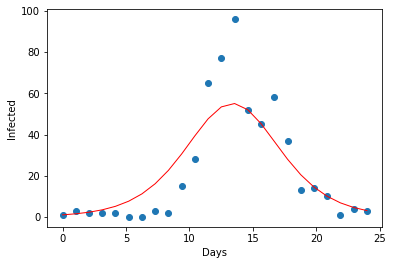

In [67]:
plot_result(slovakia_influenza_opt)

In [68]:
# SLOVENIA
slovenia_c19_start_date = "2020-03-05"
slovenia_c19_end_date = "2020-05-03"
slovenia_c19_opt = opt_covid(start_date=slovenia_c19_start_date, 
                            end_date=slovenia_c19_end_date, 
                            country=Countries.SLOVENIA, 
                            lmfit_value=35, 
                            opt_min=25.1, 
                            opt_max=50.0)

Parameters([('gamma', <Parameter 'gamma', value=44.17766881887134, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.844375092207002, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.465158153918242, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=44.92391469564109, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.94523324710913, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.689835427904804, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=49.73679104268472, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=48.00507517346878, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=35.85358092539235, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.928159397468562, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=28.061214827665214, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.746001191825727, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.496669243386762, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.95842341094321, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.173033212892424, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.10050998620564, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.607101994050424, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.601418760302934, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.506834135578377, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=49.97912595039884, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=25.74931569447201, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.705021865867405, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.66767707226834, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.40481129252531, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=42.70948027398825, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=34.19270497196805, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.850221691569395, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.89897012603768, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.102148115259748, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.063182023699053, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=41.95997768799177, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.883639938814945, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.88277257354438, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.930558621289702, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=48.283740946129406, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.147001428658363, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.260484345331506, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.77938669144971, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=31.03638627236939, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.47839910832597, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=32.29405057224976, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=33.781283658052594, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.650189727467115, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.02962270147485, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=38.195343298551904, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=38.06626281239318, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=41.95287463597152, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=45.620996355361854, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=27.18722172186922, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=43.2179537576705, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=36.86628332590787, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=45.41932901992227, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=48.283740946129406, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.584969487329822, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=30.3328287876085, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.277876669667336, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=43.48259682818655, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.10500605989425, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.42730422774369, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.661926850600523, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter

Parameters([('gamma', <Parameter 'gamma', value=28.3255880083056, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=47.60137515774652, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.383606395529657, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.787150154841576, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.868682859162945, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.138213606364413, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.35122145917019, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=27.432813038895027, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=48.742204178524304, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.49430574842221, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=25.752108227978255, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.17322825805074, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.623597246194095, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.110422893469618, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.571645476655956, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.915155878330005, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=33.22992066691341, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=28.804430543810742, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=34.29485195625708, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=35.25327823979512, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=30.835522913524613, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=31.444621890746504, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.745015079737477, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=26.276902139559482, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=28.27935889920628, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.424712743748458, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.35012217749028, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.67819013795248, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.549552535245695, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.140814849841874, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=25.476110445519545, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.43330166334637, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.182226096327135, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.400452232118813, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.61903396749265, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=32.5814865044149, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=45.54385825074039, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=46.09856247580275, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.100010209100077, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.377549051422772, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=25.217494301389486, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.356913079270253, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.922566478194923, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.10000681956493, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=45.0199927213649, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.259798560911456, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=32.78836581727425, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.107530961121295, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.2570095413516, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=37.699600701674164, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramete

Parameters([('gamma', <Parameter 'gamma', value=25.212922106378354, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.366382081097782, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.348034516447616, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.420265350688567, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=26.91787330218556, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=30.86050687772562, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.282289817076414, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=48.51549635110527, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.13980330287234, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.336875977193834, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=46.52182674501893, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.183402424621544, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.140696403454346, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.32082485941044, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.115016317500032, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.293768809816505, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=36.880050189943404, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.191570995981863, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.108836333010682, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.266060975663255, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Para

Parameters([('gamma', <Parameter 'gamma', value=40.7940605041333, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.21559790339737, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.212922106378354, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.401001815200775, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.127412756026924, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.275283599736138, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.257868996572224, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.401001815200775, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.11226967605132, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.29869283362439, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramet

Parameters([('gamma', <Parameter 'gamma', value=25.220058839354895, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.38685912385392, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.133635080102028, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.407379930581065, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.20568259648073, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.379142967788024, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.119955423130534, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.397316964080712, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.15664598969448, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.260724735512582, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Param

Parameters([('gamma', <Parameter 'gamma', value=25.102857871267158, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.283228562929036, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.109018234969522, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.279347291446523, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.113696477948857, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.27599740499289, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.103661947263884, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.21935748456369, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.1076408108133, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.269050847160972, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=25.106739325470684, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.273675118011834, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.10673931344685, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.273682450519907, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.106739317542743, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.273682450519907, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.10673931344685, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.27368247124315, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.10673931085042, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.273684038399708, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parame

Parameters([('gamma', <Parameter 'gamma', value=25.10673930712802, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.273684370164684, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.10673931122391, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.273684370164684, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.10673930712802, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.27368439088804, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.10673930712802, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.273684370164712, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=25.106739311223915, bounds=[25.1:50.0], brute_step=0>), ('beta', <Parameter 'beta', value=25.273684370164712, bounds=[25.1:50.0], brute_step=0>)])
Parameters([('gamma', <Paramet

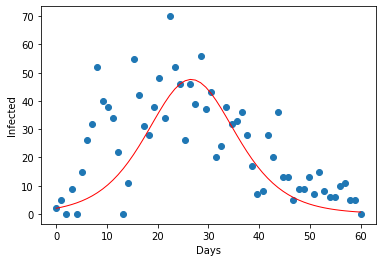

In [69]:
plot_result(slovenia_c19_opt)

In [70]:
slovenia_influenza_start_date = "2018-10-15"
slovenia_influenza_end_date = "2019-06-23"
slovenia_influenza_opt = opt_influenza(start_date=slovenia_influenza_start_date, 
                                      end_date=slovenia_influenza_end_date, 
                                      country=Countries.SLOVENIA, 
                                      lmfit_value=25.0, 
                                      opt_min=20.1, 
                                      opt_max=30.0)

Parameters([('gamma', <Parameter 'gamma', value=21.55905394492128, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.208927417624565, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.643072374410888, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.990629513921157, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.947557126163616, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.147273827906055, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=24.94576879386924, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=21.4988610163056, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.150419950501476, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=20.2137354403631, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.99376992572485, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=20.10036402708418, bounds=[20.1:30.0]>)])
Parame

Parameters([('gamma', <Parameter 'gamma', value=29.80021313737995, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.7606517836086, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.896601921047136, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.54508050009682, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.93136427622807, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.60093599617575, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.997476932861108, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.94654432287387, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.569940630145375, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.542055866721398, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.497342190793972, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.87402389279704, bounds=[20.1:30.0]>)])
Parame

Parameters([('gamma', <Parameter 'gamma', value=28.768049903459826, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.784785920192576, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.27025030335467, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=27.86683730642158, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.302989000452737, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=27.944305075837036, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.148880552561618, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.702730010357676, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.557187025400843, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=27.76564076252141, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.836630655486694, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.981254076763037, bounds=[20.1:30.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=27.11437329210269, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.32244702747746, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.616487779741238, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.706717522045626, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.233662472751526, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.702730010357676, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.69877353385334, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.270046531300068, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.23417766358448, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.420400816406733, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.874759709615624, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.601479903145997, bounds=[20.1:30.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=29.375756548911635, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.660973912071515, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.48023525799485, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.47651109865739, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.094108612013095, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.54671206377721, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.32880914277237, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.76390034169366, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.237608489667323, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.67009662964479, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.21258580229746, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.807072415570044, bounds=[20.1:30.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=24.587838525251723, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.765041006002285, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.73498466642468, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.69462532430811, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.241249451038126, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.238006807690322, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.28564630581282, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=27.990092920257467, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.973592998808787, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=27.507457526669455, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.06116691982899, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.596132523824664, bounds=[20.1:30.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=28.1200033615135, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.127669359523168, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.139534726833524, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.398336182688137, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.583271633682216, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.091044416165268, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.200696869301893, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.680602654412397, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.9358459668626, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.29671757811763, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=24.775892292918225, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.208816236562882, bounds=[20.1:30.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=25.848139946326622, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.849210345108432, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.498568062945168, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.5903784388874, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.072581389707565, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.523831283557353, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.1200033615135, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.950961569380635, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.636386130063844, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.088832928565182, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=24.032781085311463, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.512218783715376, bounds=[20.1:30.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=24.65057442445719, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.835939493417786, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.066366610664126, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.270916939116006, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.498477852960317, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=21.907572694598322, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.240235184779255, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.733139894801944, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.16027347829108, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.615777957089158, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.527384145261344, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.031648771236487, bounds=[20.1:30.0]>)])


Parameters([('gamma', <Parameter 'gamma', value=22.500170428947502, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.987403533183524, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.240235184779255, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.958858196817975, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.73895308786417, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.44352958940064, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.955698100304705, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.44759642055435, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.23293875359193, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.58220254948636, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.277837475504022, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.664625867523533, bounds=[20.1:30.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=22.576223075489747, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.062861360049006, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.771770704081582, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.20635747825531, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.641868383959874, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.12868898607116, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.08406391788965, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.556976538857548, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.71888450482961, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.2049986922989, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760718089282697, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246852257187545, bounds=[20.1:30.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=22.79768010987873, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.283533081856017, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.091200451136164, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.064715849579407, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.084241406024972, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.565781243623338, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.441669397962336, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.930705999103072, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.900466465307176, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.30371084083277, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.50203536415182, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=22.991703994798115, bounds=[20.1:30.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=22.707360028647148, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.280982792570132, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.77410168897491, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.259736031883747, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.836434450872652, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.32240994449728, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.652499834988987, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.327520504540587, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.709689766886164, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.195199418195422, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.787800170490964, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.27270692722509, bounds=[20.1:30.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=22.760939259267424, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.24667376875919, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76081314453704, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246804920073636, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760813188425676, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246804920073636, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76081314453704, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.24680496617243, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76081594904136, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246802002504783, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76081599293001, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246802002504783, bounds=[20.1:30.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=22.76082162435502, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246796268960903, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76082158046634, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246796315059665, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760821554429732, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246796306087205, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76082159831841, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246796306087205, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760821554429732, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246796352185964, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76082150161239, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.24679609359927, bounds=[20.1:30.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=22.76082154886245, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246796283689797, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760821592751128, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246796283689797, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76082154886245, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246796329788555, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760821548862776, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.24679628369106, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760821592751455, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.24679628369106, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760821548862776, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.24679632978982, bounds=[20.1:30.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=22.760820364378297, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.2467949164022, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760820408266973, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.2467949164022, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760820364378297, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246794962500957, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76082124069179, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246795927960605, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.760821284580466, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246795927960605, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.76082124069179, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.246795974059363, bounds=[20.1:30.0]>)])
Para

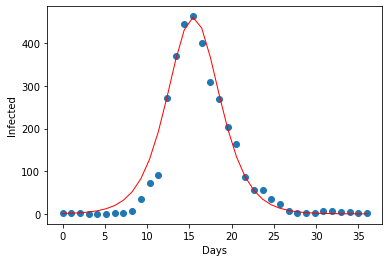

In [71]:
plot_result(slovenia_influenza_opt)

In [99]:
# SWEDEN
sweden_c19_start_date = "2020-02-01"
sweden_c19_end_date = "2020-08-28"
sweden_c19_opt = opt_covid(start_date=sweden_c19_start_date, 
                            end_date=sweden_c19_end_date, 
                            country=Countries.SWEDEN, 
                            lmfit_value=4.5, 
                            opt_min=4.0, 
                            opt_max=5.0)

Parameters([('gamma', <Parameter 'gamma', value=4.818745926345688, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.997905596123109, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.733775740229523, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.933817271404841, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.015882639433515, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.0381257982973535, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.290027455047905, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.111930885842434, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.753607090990089, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.3836263359688665, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.442

Parameters([('gamma', <Parameter 'gamma', value=4.040381857677537, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.998585050881806, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.173178968848894, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.03282959903228, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.046266387523745, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.486618696210415, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.00758345469117, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.151904434838969, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.9747184771195325, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.248241377072591, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.806155

Parameters([('gamma', <Parameter 'gamma', value=4.757883955918922, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.331239071591158, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.100264621782425, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.1705886901665155, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.660821673897132, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.679781599222747, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.6812169041606015, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.01339129578062, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.537415715789125, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.954816870643207, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.8867

Parameters([('gamma', <Parameter 'gamma', value=4.908534563098547, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.750842003789268, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.923230129635075, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.889606203362733, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.274277958334443, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.7877528409263785, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.114747072508744, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.200227423186853, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.6174609431245, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.315839469816857, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.886766

Parameters([('gamma', <Parameter 'gamma', value=4.4008518746756735, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.779765797660302, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.018572576288939, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.9574877155479395, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.534455140328494, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.927339797460336, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.544507923953435, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.879466045733116, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.902150886263709, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.125589108015592, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.187

Parameters([('gamma', <Parameter 'gamma', value=4.6174609431245, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.9484423316395425, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.5363566093841055, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.9020642776960175, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.522440856757911, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.6226471459461775, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.5364174291853985, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.630536293421036, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.676633020966078, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.993312141708401, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.73

Parameters([('gamma', <Parameter 'gamma', value=4.713000243002914, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.421207894268018, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.437333529430014, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.5261614967828665, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.434164773850761, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.525682830746464, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.297516288044083, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.348747176992614, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.71541948112153, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.485701800171595, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.89811

Parameters([('gamma', <Parameter 'gamma', value=4.533704609507716, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.606509885219818, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.525817530847573, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.586688377658245, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.722066438967053, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.803636338056453, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.454224160124995, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.632180945090688, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.498023854483732, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.555609508317143, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.58197

Parameters([('gamma', <Parameter 'gamma', value=4.4613776823773765, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.580109011101848, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.572947313184899, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.629883386856986, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.767350083465047, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.802850327551387, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.727867566387384, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.7856677387126725, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.717376587507536, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.775934506707312, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.750

Parameters([('gamma', <Parameter 'gamma', value=4.683864257603207, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.744241856813711, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.854980436648488, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.514455729956438, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.55390522889777, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.588202509296698, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.697733715805251, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.762597944410801, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.473371174338792, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.818125204881661, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.485449

Parameters([('gamma', <Parameter 'gamma', value=4.507221694501593, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.566532794533062, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.623004446369985, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.6744558445215985, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.599864930334994, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.654092256544338, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.770832476665836, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.828131331571736, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.5988892247986, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.607083974889771, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.537379

Parameters([('gamma', <Parameter 'gamma', value=4.45867679886688, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.512215771196019, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.605302419909977, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.691897774215557, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.749923204372017, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.8178638306218895, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.507581784547494, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.570331994323868, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.694237474064986, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.758686817846623, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.35859

Parameters([('gamma', <Parameter 'gamma', value=4.511499021225806, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.574628279987189, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.5200342538824225, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.583173911484794, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.53661148211217, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.600000731719595, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.488967893791684, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.621383315235973, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.500551565627481, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.5627945920732635, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.5567

Parameters([('gamma', <Parameter 'gamma', value=4.613557660302281, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.621383315235973, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.580980332439339, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.6446484163164605, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.430620975643679, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.490828816507947, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.60696090582048, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.670492440040818, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.621532765754771, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.685277509109733, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.55696

Parameters([('gamma', <Parameter 'gamma', value=4.5600920104604175, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.6238336843424275, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.560092005496659, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.623833689186653, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.56009577882596, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.623827086270658, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.560095783789714, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.623827086270658, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.56009577882596, bounds=[4.0:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.6238270911149, bounds=[4.0:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.5600924

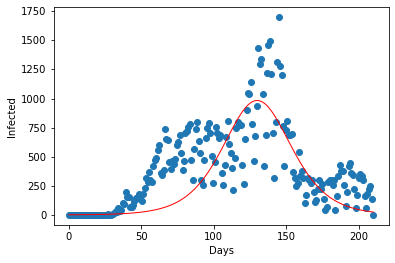

In [100]:
plot_result(sweden_c19_opt)

In [76]:
sweden_influenza_start_date = "2018-09-17"
sweden_influenza_end_date = "2019-07-14"
sweden_influenza_opt = opt_influenza(start_date=sweden_influenza_start_date, 
                                     end_date=sweden_influenza_end_date, 
                                     country=Countries.SWEDEN, 
                                     lmfit_value=25.0, 
                                     opt_min=20.1, 
                                     opt_max=30.0)

Parameters([('gamma', <Parameter 'gamma', value=20.253289246828924, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.98341873381062, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=29.626709895237415, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=20.438444985961198, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.38239009208369, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.15172727182817, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=24.0290092699865, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.62023870330878, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.102433820192278, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.834670436717616, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.587320061389384, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=21.75090130200876, bounds=[20.1:30.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=28.76283689925085, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.521290593060936, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.981701578419283, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.542133572879028, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.04080468929035, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.493524607019637, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.139579297107808, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.981232637044634, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.89129896774739, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.98341873381062, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.095971126191813, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.355053850497892, bounds=[20.1:30.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=25.618627433140666, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.662375721609784, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.01926240921951, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=20.12548233805139, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.15598667261647, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.996735457591463, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.662391387350254, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.745660318070144, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=28.463032237648424, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=29.26033388500432, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.69653555184084, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.23312851405626, bounds=[20.1:30.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=25.83307990965974, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.120512813434203, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.80969420412834, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.21149490769408, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.030328844382048, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.31051397101573, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.793290433467547, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=27.430867264420776, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.850235462728108, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.368264118309817, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=24.046262553985972, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=20.444473795289554, bounds=[20.1:30.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=25.3062215326482, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=21.771375713719145, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.588313340067714, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.07203116787193, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.298064265736386, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.731940720179438, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.80969420412834, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.672763219121563, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.270826167869057, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.549615140207578, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.66376285035882, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=21.768831594486112, bounds=[20.1:30.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=28.306520868396785, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.684601736353848, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.093923716109423, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=27.42666594233735, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.634989450495645, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.710773642233583, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.857152163203644, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=28.258173128550336, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.658148360429152, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=23.04619118484605, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=24.25990614743659, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.717241834058004, bounds=[20.1:30.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=26.32557377586211, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.747141836367607, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.157420078314782, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=27.554898849493433, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.549342292538448, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.970648890971866, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.561492928162345, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.53759109541097, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.37846816453186, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.79066491037795, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.233141010061253, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.65576517898143, bounds=[20.1:30.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=25.429493621664854, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.84600049400639, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.005134081828164, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.416343612088482, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=24.86971884997831, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.255084007307786, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.149112108033748, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.55952298189602, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.379079708894988, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.78842171767338, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.380643760934923, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.970648890971866, bounds=[20.1:30.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=25.33905279985786, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.71394816269883, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.95611663574843, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.237559310926393, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.88378973472421, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.595549216899762, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.56669593340533, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=25.97564870112764, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.153405232037667, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.587796114877793, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.92613520065619, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.33336497442182, bounds=[20.1:30.0]>)])
Parame

Parameters([('gamma', <Parameter 'gamma', value=25.936972332445315, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.615751852864516, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.977299035570113, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.391941485224944, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.939850572132144, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.418622920094037, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.108994040436666, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.523016682256095, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.254829469580287, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.681087324491358, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.16206530410685, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.576808260941945, bounds=[20.1:30.0]>)])

Parameters([('gamma', <Parameter 'gamma', value=25.989558683955416, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.40395081591319, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989558635355284, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.4039508635255, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=30.0, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=20.1, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=30.0, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=20.1, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=30.0, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=20.1, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.577426693171482, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=24.140264095970483, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.57742673573275, bounds=[20.1:30.0]

Parameters([('gamma', <Parameter 'gamma', value=25.989580843348364, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.40392202543063, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.98958079474827, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.40392207304302, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.98958030493536, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403922009723477, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.98958035353545, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403922009723477, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.98958030493536, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403922057335866, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989580740002125, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.40392202367505, bounds=[20.1:30.0]>)])
Param

Parameters([('gamma', <Parameter 'gamma', value=25.98958083697506, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.40392202522625, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.98958078837497, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.40392207283864, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989580788376852, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403922025226315, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.98958083697694, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403922025226315, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989580788376852, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403922072838704, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989580788376852, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403922025226315, bounds=[20.1:30.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=25.989572731548435, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403913746492652, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.98957278014854, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403913746492652, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989572731548435, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403913794105065, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989578025973906, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.40391918674003, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989578074574, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.40391918674003, bounds=[20.1:30.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.989578025973906, bounds=[20.1:30.0]>), ('beta', <Parameter 'beta', value=26.403919234352426, bounds=[20.1:30.0]>)])
Para

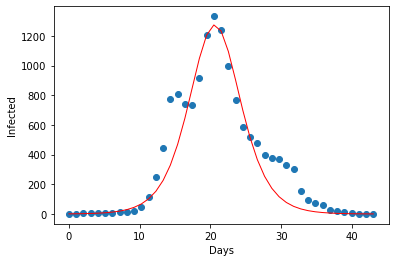

In [77]:
plot_result(sweden_influenza_opt)

In [81]:
# SWITZERLAND
switzerland_c19_start_date = "2020-02-25"
switzerland_c19_end_date = "2020-06-02"
switzerland_c19_opt = opt_covid(start_date=switzerland_c19_start_date, 
                                end_date=switzerland_c19_end_date, 
                                country=Countries.SWITZERLAND, 
                                lmfit_value=9.5, 
                                opt_min=8.1, 
                                opt_max=10.0)

Parameters([('gamma', <Parameter 'gamma', value=8.111369925783253, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.487766163438435, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.17218896097515, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.933648857630546, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.6188364047776, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.175521951639713, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.959175287580663, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.380117494425281, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.191480310300166, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.679466950716556, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=9.546560340360308, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.950530968536833, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.688144619905657, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.97810842456373, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.480234561438241, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.929942849309631, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.366691378701368, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.434029902433542, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.886949017076525, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.196026683535386, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', valu

Parameters([('gamma', <Parameter 'gamma', value=9.116959869395716, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.980905472571939, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.84565100389762, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.940909786699667, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.466512681075868, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.858786617490047, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.86274249050705, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.984525625904366, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.644761246925965, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.975442632084127, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value

Parameters([('gamma', <Parameter 'gamma', value=8.782457869342075, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.5767735512399, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.517934415078251, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.794122151237376, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.947054799596554, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.205053552741429, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.356793983029819, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.85916226378507, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.854296826742473, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.589468005700267, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=9.802331972526645, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.109564353135921, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.647059541811487, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.149873596747863, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.627237192664671, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.870687850964037, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.638258962909479, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.877819855841507, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.865814740244458, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.686641883694842, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', val

Parameters([('gamma', <Parameter 'gamma', value=9.833465216175219, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.981681350483555, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.7534444174015, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.403907862609142, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.868792807825953, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.927461968720417, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.607160703968393, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.845189648311457, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.843599651548036, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.2277916946161, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9

Parameters([('gamma', <Parameter 'gamma', value=9.067609570773865, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.870687850964037, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.926068370610974, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.999362964762051, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.72353086853047, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.891704566651905, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.702172374526082, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.926910497622663, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.307944083155906, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.9237335677379, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=9.705835868655853, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.698668034929389, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.641691334895405, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.99202765934088, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.780155130931574, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.97600902828176, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.656028074618543, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.99728277248524, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.773550305270494, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.96330448960872, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9

Parameters([('gamma', <Parameter 'gamma', value=9.879813860988227, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.987737297128467, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.744900567538615, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.98804570398171, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.709197794774315, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.988106187405755, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.74805962183293, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.978026117866586, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.759691908464871, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.978027343971743, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value

Parameters([('gamma', <Parameter 'gamma', value=9.759001010730074, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991435474724042, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758770739643529, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991474287660212, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758770745969223, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991474287660212, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758770739643529, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.9914742889301, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.757848715997502, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991628666900782, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value

Parameters([('gamma', <Parameter 'gamma', value=9.758707954775346, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991486591504536, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758707961101743, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991486591504536, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758707954775346, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991486592773512, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758736093820188, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991486592603426, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.75873610014627, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991486592603426, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', valu

Parameters([('gamma', <Parameter 'gamma', value=9.758726213612698, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991481930818319, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758726219938891, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991481930818319, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758726213612698, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.99148193208764, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758739381952541, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991485223927656, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.758739388278585, bounds=[8.1:10.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.991485223927656, bounds=[8.1:10.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', valu

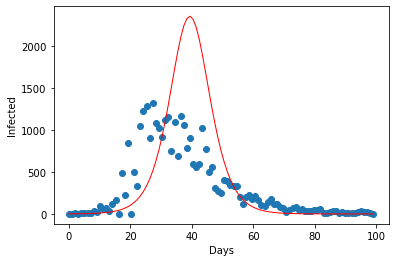

In [82]:
plot_result(switzerland_c19_opt)

In [80]:
switzerland_influenza_start_date = "2018-10-01"
switzerland_influenza_end_date = "2019-05-19"
switzerland_influenza_opt = opt_influenza(start_date=switzerland_influenza_start_date, 
                                         end_date=switzerland_influenza_end_date, 
                                         country=Countries.SWITZERLAND, 
                                         lmfit_value=50.0, 
                                         opt_min=0.1, 
                                         opt_max=100.0)

Parameters([('gamma', <Parameter 'gamma', value=8.62663027225006, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=6.882677790548397, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.6922631987441, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.22067950224103, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=2.2186128900403093, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=94.31160635735115, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=46.97560195667469, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=47.97009237713992, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=41.219426351465735, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=58.98333426083155, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=76.79411469049433, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=32.4098621116521, bounds=[0.1:100.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=19.849243080460955, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.08108463935551, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=52.76406376218509, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=82.16675726250762, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=49.10299360992378, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.99560067678304, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=34.92207123558964, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=40.2706154231152, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=76.79411469049433, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=93.96245012126903, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=59.562070062698545, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.67957214436821, bounds=[0.1:100.0]>)])
Parameter

Parameters([('gamma', <Parameter 'gamma', value=37.10454195879177, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=88.39015442246723, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=33.36906764217008, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=87.66773258468677, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=95.54607787437209, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.44891324816506, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=95.81557478424966, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.37245415510068, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=58.00987964840677, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=31.207506264945298, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=30.27115980199031, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.06857408592137, bounds=[0.1:100.0]>)])
Parameter

Parameters([('gamma', <Parameter 'gamma', value=80.30392201676209, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.22566183864967, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.66672779040535, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=94.86014019642721, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.9677976058178, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=92.97012070874858, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=99.53569152616785, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=65.35798067306175, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=48.772794773458635, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=91.99097975446219, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=63.5887019780856, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=92.42804050582609, bounds=[0.1:100.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=50.90933730206896, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=86.44176848376613, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=75.68677675112744, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=75.59380961315144, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=78.338221951522, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=78.32123273472973, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=58.236312845807475, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=89.23985886934918, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=92.05957732071613, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=95.36201227885832, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=89.03593282994916, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=91.07043305194084, bounds=[0.1:100.0]>)])
Parameters(

Parameters([('gamma', <Parameter 'gamma', value=5.074964858062684, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=96.73447173516587, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=56.56687016154337, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=56.24756279568914, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.7876951057338, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=81.16806638973921, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=31.024745159432623, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=32.62666482085225, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=53.235664425670876, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=54.65020573082169, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.44280973518536, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=80.38008999694364, bounds=[0.1:100.0]>)])
Parameter

Parameters([('gamma', <Parameter 'gamma', value=25.875554357479025, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=26.177422729647486, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=4.508463821154007, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=4.254676099057582, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=92.05957732071613, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=7.509897346851046, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=98.85391361004972, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=99.18819092328702, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=23.825512225069552, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=23.974272539415708, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=53.30085594878601, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=54.6628790721288, bounds=[0.1:100.0]>)])
Paramet

Parameters([('gamma', <Parameter 'gamma', value=3.0894170187074708, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=6.254732482086639, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=60.9489032144645, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=94.55370882705604, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=0.22037239980390877, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=16.852350750811425, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=41.33022168681509, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=74.75536247485283, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=37.663077062659106, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=68.47907958511206, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=18.005411359069893, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.013861697454143, bounds=[0.1:100.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=19.832924010521687, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.191543589663784, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=27.071106333606977, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=27.588694402350338, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.787017745237318, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=19.997611739505064, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.55335464960672, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.767914812012144, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=93.75761565825933, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=80.51348022174695, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=16.094168503582868, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=87.70868270966436, bounds=[0.1:100.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=23.279819202901038, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=52.644455055681384, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=36.35369510613475, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=36.89924822197405, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=7.099962094303896, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=7.337990666182855, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=81.87026921787141, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=53.38352757246051, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.713871498881765, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=18.00858838704876, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=80.14944731422163, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=95.26993536275891, bounds=[0.1:100.0]>)])
Paramet

Parameters([('gamma', <Parameter 'gamma', value=18.190522115093852, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=25.60442304780344, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=35.063235817577855, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=0.16550643694072176, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=22.687688092833387, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=19.327730912581526, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=39.371783391181204, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=39.82470810408008, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=3.3808667198435223, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=3.5930014230569314, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=26.449858100422528, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=22.25735289630767, bounds=[0.1:100.0]>)])


Parameters([('gamma', <Parameter 'gamma', value=13.844737885700553, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=22.918480543419733, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=18.56017077598356, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=29.395543370581827, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=31.28723862390487, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=31.6863042581021, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.915565986240384, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.278829498421945, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.79819587469245, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=22.09958762041883, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=14.530121362541157, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=14.921506726863472, bounds=[0.1:100.0]>)])
Para

Parameters([('gamma', <Parameter 'gamma', value=21.04710152485272, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=21.840143923188695, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=21.128666457222323, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=21.798976406693747, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.911370728782316, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=21.29833610946352, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.551657542067648, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.9338040035371, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=25.60119033172483, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=21.367412188024996, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=18.699453182274116, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=19.077878023161766, bounds=[0.1:100.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=19.738314666259356, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.97719637246515, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.36487452554894, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.414890331330252, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.149834066434337, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.261191443450098, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.79255637784576, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=21.178159661672844, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.491503078228757, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=21.93461761918755, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=18.346282801591414, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=18.729705299564294, bounds=[0.1:100.0]>)])
Pa

Parameters([('gamma', <Parameter 'gamma', value=20.212713948925952, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.614774147388353, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.091676853837868, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.445248810100487, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.444081411276375, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=19.846615160227934, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.921311183086683, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.296926808661834, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.62828083992525, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.99872394078264, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.080627793352527, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.463481712995225, bounds=[0.1:100.0]>)])


Parameters([('gamma', <Parameter 'gamma', value=19.758317846972155, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.725851188442984, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.35629233898619, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.737219743452794, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.412931361466217, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.802760745684918, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.1265415585155, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.513442741649236, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.413596331889863, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=19.814852230560074, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.280448534367714, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.265257775311582, bounds=[0.1:100.0]>)])
P

Parameters([('gamma', <Parameter 'gamma', value=19.8310070426095, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.036076022189647, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.967139090170615, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.354846409583967, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.957908279216017, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.354225280875344, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.912186699219237, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.3394512566994, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.292121151849937, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.670840748664656, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=19.895705527871385, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.28745350798209, bounds=[0.1:100.0]>)])
Par

Parameters([('gamma', <Parameter 'gamma', value=20.031100805898145, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.418400749421444, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.031100406665356, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.418401151537203, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.031135702172705, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.418342679954524, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.03113610140576, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.418342679954524, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.031135702172705, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.41834308206985, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.031137931647145, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.418339011944546, bounds=[0.1:100.0]>)])


Parameters([('gamma', <Parameter 'gamma', value=20.03113611367877, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.41833873580974, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.031136512911825, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.41833873580974, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.03113611367877, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.41833913792505, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.031137455671328, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.41833896444567, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.031137854904394, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.41833896444567, bounds=[0.1:100.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=20.031137455671328, bounds=[0.1:100.0]>), ('beta', <Parameter 'beta', value=20.418339366560975, bounds=[0.1:100.0]>)])
Param

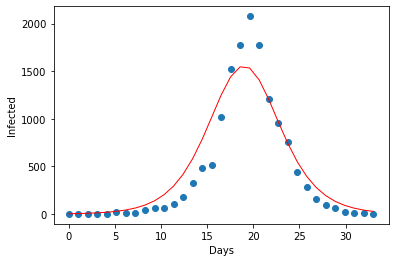

In [83]:
plot_result(switzerland_influenza_opt)

In [84]:
# UKRAINE
# Az első és a második hullám egyben van
ukraine_c19_start_date = "2020-03-03"
ukraine_c19_end_date = "2020-12-31"
ukraine_c19_opt = opt_covid(start_date=ukraine_c19_start_date, 
                            end_date=ukraine_c19_end_date, 
                            country=Countries.UKRAINE, 
                            lmfit_value=2.0, 
                            opt_min=0.1, 
                            opt_max=3.0)

Parameters([('gamma', <Parameter 'gamma', value=1.2071700357424686, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.5789404284772515, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.10996040125940121, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.2412589082703827, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.2516993345698546, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.5611421198721052, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.1860288279601283, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.5303799957819448, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.7714635395282002, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.833835167294147, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', val

Parameters([('gamma', <Parameter 'gamma', value=2.158265606795233, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.55203944178978, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.30180632217996, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.11633820660495282, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.9799448100486647, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.7293195778451212, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.16581338570704524, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.9866685052032778, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.999887721815134, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.9539907343942984, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2

Parameters([('gamma', <Parameter 'gamma', value=2.756932702410357, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.7293195778451212, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.4876347599164434, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.650965279128655, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.792810333317333, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.7484086254926983, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.882902588777409, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.920002202172506, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.0437554071066324, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.14772564638397137, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2

Parameters([('gamma', <Parameter 'gamma', value=2.179333909032366, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.601585387986785, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.9488090962620017, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.361946446732038, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.96542637504269, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.6048143131012464, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.7949339288623554, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.098393307436589, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.642863123263744, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.355862326184236, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.989

Parameters([('gamma', <Parameter 'gamma', value=2.9654021519963276, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.102674510335642, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.235163980674808, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.2415406487425344, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.124189126630413, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.5690857597668142, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.1805402896109127, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.9481811703552956, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.7202185335266096, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.8110716899347024, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=2.8861114167506887, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.920002202172506, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.79100185743457, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.8280346941746455, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.62412974113623, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.7100295745237981, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.6134534965316223, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.8183423533546836, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.7238480179631135, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.8437373086955247, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.

Parameters([('gamma', <Parameter 'gamma', value=2.5967432654260283, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.91853871821567, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.731577509139027, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7737151689688657, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9875644979794134, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.8788507864094675, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.8145062343960827, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.1375359094336801, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.950892812972938, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.9807206180596846, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2

Parameters([('gamma', <Parameter 'gamma', value=2.6036385087533565, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.91853871821567, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.6403924760900894, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7737151689688657, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.7195414613288684, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7675180787416767, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.580797577812819, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.1758478991530286, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.628731800705781, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.668740080046185, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.

Parameters([('gamma', <Parameter 'gamma', value=2.445564351483187, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7675180787416767, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.6665271245200572, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.722803493918824, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.6861376168670654, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7334448750839284, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3899761916717672, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.420822357039337, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.4428894330335846, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.486281586422388, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2

Parameters([('gamma', <Parameter 'gamma', value=2.8960068179873644, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7091800699852397, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.608752816033643, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.6931254705086176, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.717592790648442, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7568450465244654, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.2271537222978752, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.249118720934393, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.763941972124398, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.8085201046753427, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2

Parameters([('gamma', <Parameter 'gamma', value=2.538072607897281, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.7508449838960867, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.544937951392036, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.5884378689715435, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.5179565639979615, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.5593228119891465, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.721792296869861, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.76785620667883, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.515228299053337, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.5549431647679426, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3

Parameters([('gamma', <Parameter 'gamma', value=2.703004871645964, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.6895897879641755, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.413695151617233, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4537560138238477, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.4206864543336017, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4620152974160234, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.7738078977095477, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4944977162875364, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.4772110157659504, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.520446176957119, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=2.460218670116743, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.5031323036618454, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.401293637539987, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4437184572686768, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.478114013241321, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4114812408174426, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.330117075515927, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3708683456474735, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.5782475393263447, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.6203707102011893, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2

Parameters([('gamma', <Parameter 'gamma', value=2.3528088909118687, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3952934719810126, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3129000291288526, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.355074918598575, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3059830780803403, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.34936118251999, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.088004446314051, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.2879435268146553, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.1342568718548707, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.520762775159296, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.

Parameters([('gamma', <Parameter 'gamma', value=2.4876425530573054, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.531550302727583, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.4739578297368285, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.516111842564934, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.4274516049468517, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.469988195429401, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.422031544768914, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4052161647979693, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.239913228307652, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.2818929801821097, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.

Parameters([('gamma', <Parameter 'gamma', value=2.319358151916021, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4917027860674734, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.319351292101023, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.36105606714418, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3841851199312685, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.4260418761455247, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.397249165850114, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.438864693667728, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.1990305068521776, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.2401893982113315, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.1

Parameters([('gamma', <Parameter 'gamma', value=2.318603373155635, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604712840397033, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.318603519441655, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604712125317153, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.318603531736974, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604712125317153, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.318603519441655, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604712245551775, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3186046811158585, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604707401579854, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2

Parameters([('gamma', <Parameter 'gamma', value=2.3186045474895622, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604708013874194, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3186045474895636, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604707893639545, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.318604559784876, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604707893639545, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3186045474895636, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604708013874194, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.3186045474895627, bounds=[0.1:3.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.3604707893639545, bounds=[0.1:3.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', valu

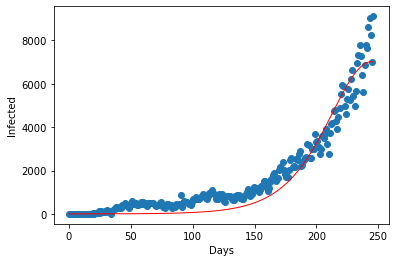

In [85]:
plot_result(ukraine_c19_opt)

In [86]:
ukraine_influenza_start_date = "2018-11-12"
ukraine_influenza_end_date = "2019-05-19"
ukraine_influenza_opt = opt_influenza(start_date=ukraine_influenza_start_date, 
                                      end_date=ukraine_influenza_end_date, 
                                      country=Countries.UKRAINE, 
                                      lmfit_value=250.0, 
                                      opt_min=200.1, 
                                      opt_max=300.0)

Parameters([('gamma', <Parameter 'gamma', value=290.0502556485659, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=212.63206819185774, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=204.191997752051, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=294.86641580287846, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=200.99046383209372, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=234.89503518468203, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=231.84181529692074, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=224.32968850214218, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=278.78641821961213, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.9220944345713, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=209.36404912846905, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.01552512297576, bou

Parameters([('gamma', <Parameter 'gamma', value=201.62072787461443, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.7608178361139, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=256.5593483645363, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.55954511749275, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=274.7766951528427, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=234.18756958176925, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=292.8972204940934, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=227.02106264141375, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=206.86371724091222, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=266.3724651995167, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=212.47571938361486, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=268.51877211143676, boun

Parameters([('gamma', <Parameter 'gamma', value=205.14192176232692, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=274.31645563764755, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=206.32077859555122, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.52165125586805, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=263.17514260027144, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=292.516380839293, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=282.3838229772804, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=250.32558317330648, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=216.09868458717017, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=286.08580275175075, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=291.03323169005114, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=259.3608045008235, bou

Parameters([('gamma', <Parameter 'gamma', value=279.96821641227984, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.0228155774506, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=227.86551460158958, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.1473490223807, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=284.9636354128425, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=293.9969609003656, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=275.43146280795173, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.6636372534497, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=254.1021652103249, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=268.53481033867564, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=267.00528985671883, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=271.32546353775706, bound

Parameters([('gamma', <Parameter 'gamma', value=239.80957128809982, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=280.9132005653582, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=211.36063802011253, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=291.7760781546936, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=291.66964486739164, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=267.8467469107171, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=293.1403460917928, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=259.3608045008235, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=269.34638517597944, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=269.47669073683255, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=293.91989432020017, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=293.9739028297566, bound

Parameters([('gamma', <Parameter 'gamma', value=272.4681711414634, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=273.95048949511903, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.35560121151224, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=297.95404481959093, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=294.2538918182947, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=294.92906318164927, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=293.41221229748214, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=295.37715415821634, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=295.7028505859426, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=280.02105505420457, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.35785395535794, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.801292568148, boun

Parameters([('gamma', <Parameter 'gamma', value=296.4212537703455, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=297.0424859565651, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=293.21898163696835, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.97813974109886, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=295.0575222740015, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=295.6374477040971, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.24907511852496, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.8666555798623, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=293.30359493907724, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=293.9984402071222, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=296.51368864427354, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=297.11597010705054, bound

Parameters([('gamma', <Parameter 'gamma', value=296.2327588525752, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=296.90948769223655, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.4815059000232, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.0388201808249, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.5758208249108, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=297.17888481822035, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.1112393672948, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.73104921801564, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.92833254379065, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.56025897623476, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=294.4009092292092, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=295.16252951326305, bound

Parameters([('gamma', <Parameter 'gamma', value=296.22598257201986, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=297.76364940751546, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.4787361960132, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2662137668851, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.77774604315425, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.36566101284524, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=290.9554039371272, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=291.70527716184915, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=296.2327588525752, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.13258066169135, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.95676852011, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.6140091869893, bounds=

Parameters([('gamma', <Parameter 'gamma', value=298.76693076798034, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.3424105155382, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.76224161982634, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.46373164529643, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=293.30359493907724, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.12685512454783, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=299.14320045564364, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.66139602513056, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.315514638698, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.208820285077, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.0979163992827, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.79964723702744, bound

Parameters([('gamma', <Parameter 'gamma', value=298.3015380890283, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.96292075904194, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.0851011582462, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.77794268080083, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.83859413338666, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.5178439154831, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.543411978922, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.17963805849547, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.37157533851985, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.04052513996476, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.9264512883782, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.0637985712792, bounds

Parameters([('gamma', <Parameter 'gamma', value=298.05529871853173, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.7342971887681, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.55758164937765, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2043345364203, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.0928390207653, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.4073142802339, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.5643559360102, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.22496280412906, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.095952475026, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.77881272561115, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.3447547113721, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.0166208346337, bounds=[

Parameters([('gamma', <Parameter 'gamma', value=297.88994068199247, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.5480852405052, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.14372203532116, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.8163415329658, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.2962192741503, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.95760387451503, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.7386545652993, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.6027351275536, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=297.3988788660924, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.04625224671395, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.19083194338907, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.8539849922763, bounds

Parameters([('gamma', <Parameter 'gamma', value=298.50073647366565, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.1707313762125, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.4443266293109, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.29820234416877, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.91717463933895, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.544716460721, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.21755164378453, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.8863052002889, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.5798417795433, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.24836983414104, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.314957088166, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=298.99392972439955, bounds=

Parameters([('gamma', <Parameter 'gamma', value=298.6119701723741, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.27936441718197, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.6119700554392, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793645017232, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61209811821766, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.27936375414555, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.6120982351472, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.27936375414555, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61209811821766, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793638386868, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61210810004394, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.279363702464, bounds

Parameters([('gamma', <Parameter 'gamma', value=298.61210888581, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.27936369809083, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.6121090027391, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.27936369809083, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61210888581, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793637826321, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61210888580956, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793636980908, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61210900273863, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793636980908, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61210888580956, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.27936378263206, bounds=[2

Parameters([('gamma', <Parameter 'gamma', value=298.61208406222306, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793453412305, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61208417915316, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793453412305, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61208406222306, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793454257728, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.6121024524408, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793589406683, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.61210256937017, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793589406683, bounds=[200.1:300.0]>)])
Parameters([('gamma', <Parameter 'gamma', value=298.6121024524408, bounds=[200.1:300.0]>), ('beta', <Parameter 'beta', value=299.2793590252098, bounds=

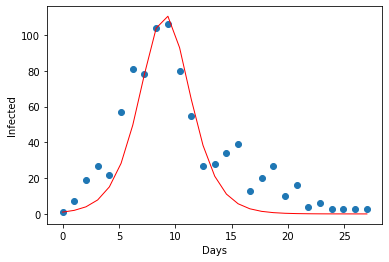

In [87]:
plot_result(ukraine_influenza_opt)

In [90]:
# USA
# Az első és a második hullám egyben van
usa_c19_start_date = "2020-01-24"
usa_c19_end_date = "2020-12-31"
usa_c19_opt = opt_covid(start_date=usa_c19_start_date, 
                        end_date=usa_c19_end_date, 
                        country=Countries.USA, 
                        lmfit_value=2.0, 
                        opt_min=0.1, 
                        opt_max=5.0)

Parameters([('gamma', <Parameter 'gamma', value=4.997761121586724, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.514792258581647, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.24680764096746252, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.0220293900733513, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.9896070449500027, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.025206633815242, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.953304698431159, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.7286317018577765, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.538039706212343, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.382549449046047, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.

Parameters([('gamma', <Parameter 'gamma', value=1.1421092463084768, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.8913419396235317, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.9991142151839165, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.758343359655741, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9581437269322124, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.23586980525063725, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.6893271841452397, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.193552177678391, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.9987371536014304, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.804611315928332, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value

Parameters([('gamma', <Parameter 'gamma', value=4.904015562659923, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.999865122830858, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.2114194924065793, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.386401348396764, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.953304698431159, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.857260424363399, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.0101549551444595, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.911774021542342, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.749275512283754, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.8500846363453365, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.20

Parameters([('gamma', <Parameter 'gamma', value=4.992806987073684, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.837823895019745, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.985309841697732, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.8221520553579635, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.951423787534101, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.40440839107947013, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.671887459533193, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.3237452999815327, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.73473181486479, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.706447102559326, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.75

Parameters([('gamma', <Parameter 'gamma', value=4.7108518423444785, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.954700912847355, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.7487424005749386, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.101395638219323, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.889272927038565, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.301415439889492, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.863058066764275, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.947718504858011, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.879184815198455, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.967833920468329, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.944

Parameters([('gamma', <Parameter 'gamma', value=4.932343031132664, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.3192903899814752, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.745598676302744, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.719890735957512, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.786709624480077, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.806459088766175, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.911313276115584, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.96881645005815, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.915588678214478, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.8300907784242323, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.9353

Parameters([('gamma', <Parameter 'gamma', value=4.912320847629689, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.983085531568752, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.7432617938817465, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.727541166999457, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.794429402649346, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.8669813035021505, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.938372681760855, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.5521401180945765, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.959592436521257, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.742639273936998, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.81

Parameters([('gamma', <Parameter 'gamma', value=4.819705273500715, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.897411839658916, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.798547089319929, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.874467931050548, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.8384875229183475, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.922946812499632, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.885203753966482, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.848726074556395, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.8546160644169305, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.940338262472042, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.810

Parameters([('gamma', <Parameter 'gamma', value=4.783292303995492, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.860781517366368, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.857829969616842, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.9166654101461535, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.764028739267337, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.837815000501913, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.7795082286794885, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.854280741512249, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.804613305590668, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.881051872584697, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.724

Parameters([('gamma', <Parameter 'gamma', value=4.436432435028558, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.499601166585026, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.427883904114327, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.491070024658468, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.485085498920567, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.555758323972598, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.3084286800224465, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.365077733077342, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.625945622961418, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.705417476006452, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.7944

Parameters([('gamma', <Parameter 'gamma', value=3.854663494331396, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.891454385693207, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.685382263875943, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.780195303473154, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.40447576481924, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.495680635713549, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.666126339510612, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.60869756853816, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.874446965460369, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.915580601897354, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.0869463

Parameters([('gamma', <Parameter 'gamma', value=3.955478298314406, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.017621428137911, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.395282346528807, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.47236711089862, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.134229269699469, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.20433648112653, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.3150214728390415, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.388627119904655, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.965435219978386, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.031231084482329, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.981861

Parameters([('gamma', <Parameter 'gamma', value=4.190493370509609, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=4.277630764641188, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.7736485990528297, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.8416204391775293, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1524929282973044, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.1942892663618867, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.2845515649094663, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.336797080543658, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.8540345786329295, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.9506029567395897, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=3.5635875894513407, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.6312391778906368, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.369460624469098, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.4445278122635368, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.6550455438400498, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.6974383504194663, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.4399572377203906, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.5183775473040515, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.436186529761844, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.508312501490193, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=3.0826527653008475, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.1556081451649374, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.2059470585525673, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2836742530529492, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.144913058902228, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.21432712339228, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.362236277453305, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.3909878795293786, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.412594016483678, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=2.9267749507523226, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=2.

Parameters([('gamma', <Parameter 'gamma', value=3.320028772966732, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.3877016493861265, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.2168778023773252, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2861935020516566, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.0822860880328995, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.150477063047222, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.009593662539243, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.50098810952206, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.185264772061448, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2158805097615755, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.4

Parameters([('gamma', <Parameter 'gamma', value=3.281325999227518, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.350409475992956, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.232697180805677, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.302355065469106, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1986822265297477, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.26797926934225, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1773204991049813, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.246857451323724, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.149998075500997, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.218449437526336, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.2632

Parameters([('gamma', <Parameter 'gamma', value=3.1987019175352165, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.267952394954675, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1987019411608077, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.267952394954675, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1987019175352165, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2679524183791155, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1987018563215837, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2679525713005595, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.198701879947176, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2679525713005595, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=

Parameters([('gamma', <Parameter 'gamma', value=3.1987018563215837, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.267952594725, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1987018563215845, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2679525713005497, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1987018799471767, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2679525713005497, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1987018563215845, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.26795259472499, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.1, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.1, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.1, bounds=[0.1:5.0], brute_step

Parameters([('gamma', <Parameter 'gamma', value=3.1987018090162915, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2679525236472173, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1987018326418832, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2679525236472173, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.1987018090162915, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.2679525470716575, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.198701846538992, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.267952561445992, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.198701870164584, bounds=[0.1:5.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.267952561445992, bounds=[0.1:5.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3

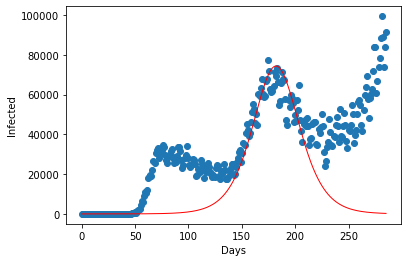

In [91]:
plot_result(usa_c19_opt)

In [37]:
# USA
# Az első hullám egyben van
usa_c19_1_start_date = "2020-03-01"
usa_c19_1_end_date = "2020-05-20"
usa_c19_1_opt = opt_covid(start_date=usa_c19_1_start_date, 
                        end_date=usa_c19_1_end_date, 
                        country=Countries.USA, 
                        lmfit_value=7.0, 
                        opt_min=0.1, 
                        opt_max=15.0)

Parameters([('gamma', <Parameter 'gamma', value=1.618115222116531, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.6122696259608171, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.883589842450299, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.5750160318101268, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.816679988825893, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.260759941821335, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.0055656156556783, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.24331770126062383, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.619174523420308, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.8702651693881815, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=14.530180527624294, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.692610446819058, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.860647434305317, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.651909382464597, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.138705936399381, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.020342617398311, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.994182529322194, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.945740110352448, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.751833649619783, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.6122696259608171, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=10.506213567105753, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.349560678080577, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.05742554137336, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.86450209775987, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=0.3598082018059052, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.194074870874198, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.838351503283114, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.113416221106379, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=4.646255091561648, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.021276027560823, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=13.750148855799354, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.847471497000404, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.12026616214928, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.981810193260978, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.365687798688805, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.168749279587098, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.764163668636787, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.826063557440126, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.253845645575497, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.210712060572341, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

Parameters([('gamma', <Parameter 'gamma', value=12.852346986145477, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.328164050379584, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.855693931945954, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.149166102413746, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.66804331491126, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.363197413530489, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.416755103901106, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=6.971398891387161, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.007180619567292, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.864960600444212, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', 

Parameters([('gamma', <Parameter 'gamma', value=13.223521698528815, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.826063557440126, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.326379082754256, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.031481376639983, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.874006874236262, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.421252296902153, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=1.9373512108893305, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=1.9928775905328187, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.470740569463365, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.68102061276442, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=8.547966500824668, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.487909951535634, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=14.836138170000288, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=8.333946844311946, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=8.499776680873836, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=0.2041327408146683, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.08442641668932, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.831734556485895, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.065026543444063, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=14.400519056466997, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma'

Parameters([('gamma', <Parameter 'gamma', value=4.248308203022577, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.56660179067565, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=6.988720211298969, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=7.2594667624343145, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=3.0175113074471476, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=3.05593085570053, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=13.689124552568876, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.9125595927514, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=5.584408790151985, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=5.871917248075488, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', va

Parameters([('gamma', <Parameter 'gamma', value=11.730126237242388, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.940499210430366, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.728576400322764, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.909066104017594, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.564701699998393, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.786467092248264, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.203733176783077, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.415656372586898, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=9.790865430914574, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=9.883105165712012, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gam

Parameters([('gamma', <Parameter 'gamma', value=10.791962854792787, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.93862735762693, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.123264716960682, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.31823645290172, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.45678331157717, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.636865200659523, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.57686616103514, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.6025287356705, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.86569607847505, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=13.116140092302436, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', 

Parameters([('gamma', <Parameter 'gamma', value=12.101034450850001, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.285185436762976, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.68347291064537, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.84781512374134, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.607977800510346, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.05741580778035, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.163645597755677, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.325149276816438, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.218629063999268, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.379292658607062, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=12.25759395687165, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.853913439163618, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.823367231238905, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.982506201576628, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=12.118173670640747, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.307278047713494, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.660640683979464, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=10.825009868393446, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.4997801878691, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.670179844032669, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=11.16220279266865, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.32806628232422, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.286321580090284, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.458414812506124, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.893871457312457, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.05505628681181, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=10.864298842024601, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.632285400425014, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.520385962497055, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.706787190538034, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=11.304890186781634, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.470618555043778, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.202561930852745, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.368705604362102, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.550433246493515, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.72085933725905, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.831660000008911, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=12.0079714113219, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.537259670934942, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.706541916869266, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamm

Parameters([('gamma', <Parameter 'gamma', value=11.346595584313127, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.49226551308489, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.34659564841333, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.49226551308489, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.346595584313127, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.492265576299637, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.33907583712716, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.507483360495788, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.339075901271842, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.507483360495788, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma

Parameters([('gamma', <Parameter 'gamma', value=11.33820598746777, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.509209524972151, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.338206000554345, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.509209461829897, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.338206064704165, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.509209461829897, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.338206000554345, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.509209524938662, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'gamma', value=11.338206001941892, bounds=[0.1:15.0], brute_step=0>), ('beta', <Parameter 'beta', value=11.509209461826346, bounds=[0.1:15.0], brute_step=0>)])
Parameters([('gamma', <Parameter 'ga

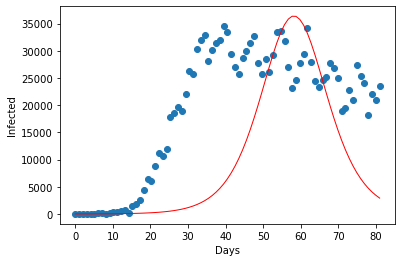

In [38]:
plot_result(usa_c19_1_opt)